### Farhad's project (2019-02-25_Farhad_algae_model) modified:
- comments in code
- original raw data files imported and processed within the code
- nan values replaced with numpy nan to leave them in the code
- Linear regression, SVR
- Baseline prediction comparison 
- Scaling 
- Hyperparam tuning 

# Importing the libraries we are going to use:

In [169]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import copy
import sys
print(sys.version)

# #########################

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPClassifier

# Imputing missing values and scaling values
from sklearn.preprocessing import MinMaxScaler

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Evaluating performance
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


# Reading the raw data and saving it in a variable called: df_algae

In [2]:
headings = ['season','size','speed','mxPH','mnO2','Cl', 'NO3','NH4','oPO4','PO4','Chla','1','2','3','4','5','6','7'];
headings = ['Season','Size','Speed','F1'  ,'F2'  ,'F3', 'F4' ,'F5' ,'F6'  ,'F7' ,'F8'  ,'1','2','3','4','5','6','7'];

df_algae = pd.read_csv("original_data/analysis.csv",         # algal_bloom.csv is raw data!
                   #skiprows=list(range(10)), 
                   names=headings)  
print('**************  df_algae looks like:')
df_algae.head()

**************  df_algae looks like:


Season    Size   Speed       F1        F2        F3        F4         F5  \
0  winter  small_  medium  8.00000   9.80000  60.80000   6.23800  578.00000   
1  spring  small_  medium  8.35000   8.00000  57.75000   1.28800  370.00000   
2  autumn  small_  medium  8.10000  11.40000  40.02000   5.33000  346.66699   
3  spring  small_  medium  8.07000   4.80000  77.36400   2.30200   98.18200   
4  autumn  small_  medium  8.06000   9.00000  55.35000  10.41600  233.70000   

          F6         F7        F8    1     2     3    4     5    6    7  
0  105.00000  170.00000  50.00000  0.0   0.0   0.0  0.0  34.2  8.3  0.0  
1  428.75000  558.75000   1.30000  1.4   7.6   4.8  1.9   6.7  0.0  2.1  
2  125.66700  187.05701  15.60000  3.3  53.6   1.9  0.0   0.0  0.0  9.7  
3   61.18200  138.70000   1.40000  3.1  41.0  18.9  0.0   1.4  0.0  1.4  
4   58.22200   97.58000  10.50000  9.2   2.9   7.5  0.0   7.5  4.1  1.0

## Missing Values and Type Conversion

In [3]:
# Replace all occurrences of XXXXXXX with numpy not a number
df_algae = df_algae.replace({'XXXXXXX': np.nan})

# Replace all missing values with numpy not a number
df_algae.fillna(value=pd.np.nan, inplace=True);

# Cast all numerical values as float
for heading in headings[3:]:
    for row in range(df_algae.shape[0]): 
        try:
            df_algae[heading][row] = float(df_algae[heading][row])
            
        except ValueError: 
            try:
                # Trim numbers containing illegal characters 
                # Convert to float
                df_algae[heading][row] = float(df_algae[heading][row][:4])
            except ValueError:
                print(df_algae[heading][row])

# Cast all data as np 64 bit float to allow operations such as logarithms
for heading in headings[3:]:
    df_algae[heading] = df_algae[heading].astype(np.float64)

In [4]:
print(type(df_algae['F1'][5]))

<class 'numpy.float64'>


# Basic info about the dataset:

In [5]:
df_algae.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 18 columns):
Season    200 non-null object
Size      200 non-null object
Speed     200 non-null object
F1        199 non-null float64
F2        198 non-null float64
F3        190 non-null float64
F4        198 non-null float64
F5        198 non-null float64
F6        198 non-null float64
F7        198 non-null float64
F8        188 non-null float64
1         200 non-null float64
2         200 non-null float64
3         200 non-null float64
4         200 non-null float64
5         200 non-null float64
6         200 non-null float64
7         183 non-null float64
dtypes: float64(15), object(3)
memory usage: 28.2+ KB


# We have some null values which we should deal with; First, let's see where they are:

In [6]:
print(df_algae.isnull().sum())

Season     0
Size       0
Speed      0
F1         1
F2         2
F3        10
F4         2
F5         2
F6         2
F7         2
F8        12
1          0
2          0
3          0
4          0
5          0
6          0
7         17
dtype: int64


For example, in 12 rows, we do not have the value of F8

# A simple way, is jut to drop the rows with unknown values:

In [7]:
df_algae=df_algae.dropna()
# this will index the rows again. 
# Without this, the indexes will remain the same 
# (The rows won't shift up)
df_algae.index = range(len(df_algae)) 
print ("We have", df_algae.isnull().values.sum(), " row(s) with unknown value now" )

We have 0  row(s) with unknown value now


In [8]:
print('**************  df_algae, after removing the unknown rows, looks like:')
df_algae.head()

**************  df_algae, after removing the unknown rows, looks like:


Season    Size   Speed    F1    F2      F3      F4         F5       F6  \
0  winter  small_  medium  8.00   9.8  60.800   6.238  578.00000  105.000   
1  spring  small_  medium  8.35   8.0  57.750   1.288  370.00000  428.750   
2  autumn  small_  medium  8.10  11.4  40.020   5.330  346.66699  125.667   
3  spring  small_  medium  8.07   4.8  77.364   2.302   98.18200   61.182   
4  autumn  small_  medium  8.06   9.0  55.350  10.416  233.70000   58.222   

          F7    F8    1     2     3    4     5    6    7  
0  170.00000  50.0  0.0   0.0   0.0  0.0  34.2  8.3  0.0  
1  558.75000   1.3  1.4   7.6   4.8  1.9   6.7  0.0  2.1  
2  187.05701  15.6  3.3  53.6   1.9  0.0   0.0  0.0  9.7  
3  138.70000   1.4  3.1  41.0  18.9  0.0   1.4  0.0  1.4  
4   97.58000  10.5  9.2   2.9   7.5  0.0   7.5  4.1  1.0

# Here, we copy the columns that have categorical (non-numeric) data to a new variable called cat_df_algae:

In [9]:
cat_df_algae = df_algae.select_dtypes(include=['object']).copy()# object data type mens categorical data type
df_algae_fin = df_algae.copy()# Just to keep the data set we have safe! Not important!
print('**************  cat_df_algae looks like:')
cat_df_algae.head()

**************  cat_df_algae looks like:


Season    Size   Speed
0  winter  small_  medium
1  spring  small_  medium
2  autumn  small_  medium
3  spring  small_  medium
4  autumn  small_  medium

# Now, we start label binarizing for the first categorical feature (Size, the first section):

The following 3 sections are the same, each is related to one feature.

In [10]:
#Here, again I just copy the variable to keep it safe. 
cat_df_algae_onehot_sklearn = cat_df_algae.copy()

# This is the function form Sklearn
from sklearn.preprocessing import LabelBinarizer 

lb = LabelBinarizer()

lb_results = lb.fit_transform(cat_df_algae_onehot_sklearn['Size'])

lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

# Here, I am attaching the generated labels to the data we had
result_df = pd.concat([lb_results_df,df_algae], axis=1) 

res_1=result_df.copy()

In [11]:
cat_df_algae_onehot_sklearn = cat_df_algae.copy()
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb_results = lb.fit_transform(cat_df_algae_onehot_sklearn['Speed'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
result_df = pd.concat([lb_results_df,df_algae_fin], axis=1)
res_2=result_df.copy()
res_2 = pd.concat([lb_results_df,res_1], axis=1)

In [12]:
cat_df_algae_onehot_sklearn = cat_df_algae.copy()
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb_results = lb.fit_transform(cat_df_algae_onehot_sklearn['Season'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
result_df = pd.concat([lb_results_df,df_algae_fin], axis=1)
res_3=result_df.copy()
res = pd.concat([lb_results_df,res_2], axis=1)

# Finally, we drop the categorical data related columns and write the excel file:

In [13]:
res=res.drop(['Size', 'Season','Speed'], axis=1)
res.to_excel("data/polished_train_data.xls")
res.to_csv("data/polished_train_data.csv", index = False)
res.head()

autumn  spring  summer  winter  high__  low___  medium  large_  medium  \
0       0       0       0       1       0       0       1       0       0   
1       0       1       0       0       0       0       1       0       0   
2       1       0       0       0       0       0       1       0       0   
3       0       1       0       0       0       0       1       0       0   
4       1       0       0       0       0       0       1       0       0   

   small_ ...        F6         F7    F8    1     2     3    4     5    6    7  
0       1 ...   105.000  170.00000  50.0  0.0   0.0   0.0  0.0  34.2  8.3  0.0  
1       1 ...   428.750  558.75000   1.3  1.4   7.6   4.8  1.9   6.7  0.0  2.1  
2       1 ...   125.667  187.05701  15.6  3.3  53.6   1.9  0.0   0.0  0.0  9.7  
3       1 ...    61.182  138.70000   1.4  3.1  41.0  18.9  0.0   1.4  0.0  1.4  
4       1 ...    58.222   97.58000  10.5  9.2   2.9   7.5  0.0   7.5  4.1  1.0  

[5 rows x 25 columns]

# Now we will do the same for the test data:

- read raw data into data frame
- (new: Missing Values and Type Conversion)
- drop rows with unknown data
- copy columns with catagorical data to new variable
- binarize catagorical data
- remove catagorical data columns 
- save polished data in new file




In [14]:
# Reading the raw data and saving it in a variable called: df_algae
# df_algae = pd.read_excel('eval_result_data.xls') #eval_result_data is the raw test data!
headings = ['Season','Size','Speed','F1'  ,'F2'  ,'F3', 'F4' ,'F5' ,'F6'  ,'F7' ,'F8'  ,'1','2','3','4','5','6','7'];



df_algae = pd.read_csv("original_data/results.csv",         # algal_bloom.csv is raw data!
                   #skiprows=list(range(10)), 
                   names=headings)

df_algae.head() 

# # Missing Values and Type Conversion
# Replace all occurrences of XXXXXXX with numpy not a number
df_algae = df_algae.replace({'XXXXXXX': np.nan})

# Replace all missing values with numpy not a number
df_algae.fillna(value=pd.np.nan, inplace=True);

# Cast all numerical values as float
for heading in headings[3:]:
    for row in range(df_algae.shape[0]): 
        try:
            df_algae[heading][row] = float(df_algae[heading][row])
            
        except ValueError: 
            try:
                # Trim numbers containing illegal characters 
                # Convert to float
                df_algae[heading][row] = float(df_algae[heading][row][:4])
            except ValueError:
                print(df_algae[heading][row])

# Cast all data as np 64 bit float to allow operations such as logarithms
for heading in headings[3:]:
    df_algae[heading] = df_algae[heading].astype(np.float64)

df_algae.head()    



Season    Size   Speed    F1    F2      F3     F4         F5         F6  \
0  summer  small_  medium  7.95   5.7  57.333  2.460  273.33301  295.66699   
1  winter  small_  medium  7.98   8.8  59.333  7.392  286.66699   33.33300   
2  summer  small_  medium  8.00   7.2  80.000  1.957  174.28600   47.85700   
3  spring  small_  high__  8.35   8.4  68.000  3.026  458.00000   45.20000   
4  spring  small_  medium  8.10  13.2  19.000  0.000  130.00000    6.00000   

        F7   F8    1     2    3    4     5     6     7  
0  380.000  NaN  1.2  36.5  1.9  0.0   1.2   0.0  28.0  
1  138.000  7.1  1.2   0.0  0.0  0.0  23.2  46.4   0.0  
2  113.714  4.5  7.0  23.0  6.5  1.4  21.2   0.0   2.1  
3  111.800  3.2  1.4  38.2  2.4  0.0   4.8   1.0   1.2  
4   40.000  2.0  3.9  55.4  8.4  0.0   0.0   0.0   0.0

In [15]:
# Drop rows with unknown data
df_algae=df_algae.dropna()
# this will index the rows again. 
# Without this, the indexes will remain the same 
# (The rows won't shift up)
df_algae.index = range(len(df_algae)) 
print ("We have", df_algae.isnull().values.sum(), " row(s) with unknown value now")
df_algae.head()

# Copy the columns that have categorical data to a new variable called cat_df_algae
# object data type mens categorical data type
cat_df_algae = df_algae.select_dtypes(include=['object']).copy()
# Just to keep the data set we have safe! Not important!
df_algae_fin = df_algae.copy()
cat_df_algae.head()

We have 0  row(s) with unknown value now


Season    Size   Speed
0  winter  small_  medium
1  summer  small_  medium
2  spring  small_  high__
3  spring  small_  medium
4  summer  small_  medium

In [16]:
# We start label binarizing for the first categorical feature 
# (Size, the first section)
# Here, again I just copy the variable to keep it safe.
cat_df_algae_onehot_sklearn = cat_df_algae.copy() 
from sklearn.preprocessing import LabelBinarizer 
lb = LabelBinarizer()
lb_results = lb.fit_transform(cat_df_algae_onehot_sklearn['Size'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
# Here, I am attaching the generated labels to the data we had
result_df = pd.concat([lb_results_df,df_algae], axis=1) 
res_1=result_df.copy()

cat_df_algae_onehot_sklearn = cat_df_algae.copy()
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb_results = lb.fit_transform(cat_df_algae_onehot_sklearn['Speed'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
result_df = pd.concat([lb_results_df,df_algae_fin], axis=1)
res_2=result_df.copy()
res_2 = pd.concat([lb_results_df,res_1], axis=1)

cat_df_algae_onehot_sklearn = cat_df_algae.copy()
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb_results = lb.fit_transform(cat_df_algae_onehot_sklearn['Season'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
result_df = pd.concat([lb_results_df,df_algae_fin], axis=1)
res_3=result_df.copy()

# Drop catagorical data columns
res = pd.concat([lb_results_df,res_2], axis=1)
res=res.drop(['Size', 'Season','Speed'], axis=1)

# Save polished data in new file
res.to_excel("data/polished_test_data.xls")
res.to_csv("data/polished_test_data.csv", index = False)
res.head()

autumn  spring  summer  winter  high__  low___  medium  large_  medium  \
0       0       0       0       1       0       0       1       0       0   
1       0       0       1       0       0       0       1       0       0   
2       0       1       0       0       1       0       0       0       0   
3       0       1       0       0       0       0       1       0       0   
4       0       0       1       0       0       0       1       0       0   

   small_ ...       F6       F7    F8     1     2    3    4     5     6    7  
0       1 ...   33.333  138.000   7.1   1.2   0.0  0.0  0.0  23.2  46.4  0.0  
1       1 ...   47.857  113.714   4.5   7.0  23.0  6.5  1.4  21.2   0.0  2.1  
2       1 ...   45.200  111.800   3.2   1.4  38.2  2.4  0.0   4.8   1.0  1.2  
3       1 ...    6.000   40.000   2.0   3.9  55.4  8.4  0.0   0.0   0.0  0.0  
4       1 ...    5.000   10.507  13.8  28.4   2.4  0.0  0.0   0.0   0.0  4.6  

[5 rows x 25 columns]

# END OF DATA POLISHING !
 ***********************************************************************************************

# Using Support Vector Regression method (sklearn library) :

In statistics, mean absolute error (MAE) is a measure of difference between two continuous variables. Assume X and Y are variables of paired observations that express the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. Consider a scatter plot of n points, where point i has coordinates (xi, yi)... Mean Absolute Error (MAE) is the average vertical distance between each point and the identity line. MAE is also the average horizontal distance between each point and the identity line.

The mean absolute error is given by:



\begin{align}
\mathrm{MAE} = \frac {\sum _{i=1}^{n}\left|y_{i}-x_{i}\right|}{n} = \frac {\sum _{i=1}^{n}\left|e_{i}\right|}{n}
\end{align}




The normalized mean squared error is given by:



\begin{align}
\mathrm{MAE} = \frac{1}{n} \sum _{i=1}^{n}\left|y_{i}-x_{i}\right| \frac {}{n} = \frac {\sum _{i=1}^{n}\left|e_{i}\right|}{n}
\end{align}



The NMSE (Normalised Mean Square Error) is an estimator of the overall deviations between predicted and measured values. in the NMSE the deviations (absolute values) are summed instead of the differences. For this reason, the NMSE generally shows the most striking differences among models. If a model has a very low NMSE, then it is well performing both in space and time. On the other hand, high NMSE values do not necessarily mean that a model is completely wrong. That case could be due to time and/or space shifting. Moreover, it must be pointed out that differences on peaks have a higher weight on NMSE than differences on other values.


The normalized mean squared error is given by:



\begin{align}
\mathrm{NMSE} = \frac{1}{n} \sum _{i=1}^{n} \frac{\left(y_{i}-x_{i}\right)^2}{\bar{y} \bar{x}} \\
\bar{y} = \frac{1}{n} \sum _{i=1}^{n}y_{i}\\
\bar{x} = \frac{1}{n} \sum _{i=1}^{n}x_{i}
\end{align}



## python funtions to calculate loss functions

In [172]:
# # Function to calculate mean absolute error
# def mae(y_true, y_pred):
#     return np.mean(abs(y_true - y_pred))


# Function to calculate normalized mean squared error
def nmse(y_true, y_pred):
    #return mse(normalize(y_true), normalize(y_pred))
    return mse(normalize(y_true), normalize(y_pred))

In [181]:
def evaluate(mod_name, model, A,
             x_train, y_train, y_pred_train, 
             x_test, y_test, y_pred_test):
    """
    Evaluates loss functions for fitted model on test, training and baseline data.
    Stores results in dictionary.
    """
    
    
    # baseline performance
    baseline_guess = np.median(y_train)
    
    # Mean absolute error
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mae_baseline = mean_absolute_error(y_test, np.full_like(y_test.reshape(-1, 1),baseline_guess))
    results[mod_name + "_mae_train_" + A] = mae_train
    results[mod_name + "_mae_test_" + A] = mae_test
    results[mod_name + "_mae_baseline_" + A] = mae_baseline
    
    
    # Normalized mean squared error
    nmse_train = np.round( nmse(y_train.reshape(-1, 1), y_pred_train.reshape(-1, 1)),
                            decimals=3 ) 

   
    nmse_test = np.round( nmse(y_test.reshape(-1, 1), y_pred_test.reshape(-1, 1)), 
                           decimals=3 ) 
    
    nmse_baseline = np.round( nmse(y_test.reshape(-1, 1), np.full_like(y_test.reshape(-1, 1),baseline_guess)),
                               decimals=3 )     
    results[mod_name + "_nmse_train_" + A] = nmse_train
    results[mod_name + "_nmse_test_" + A] = nmse_test
    results[mod_name + "_nmse_baseline_" + A] = nmse_baseline
    
    
    
    # root mean squared error
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmse_baseline = np.sqrt(mean_squared_error(y_test, np.full_like(y_test.reshape(-1, 1),baseline_guess)))



    

In [187]:
def evaluate(mod_name, model, A,
             x_train, y_train, y_pred_train, 
             x_test, y_test, y_pred_test):
    """
    Evaluates loss functions for fitted model on test, training and baseline data.
    Stores results in dictionary.
    """
    
    
    # baseline performance
    baseline_guess = np.median(y_train)
    
    
    # Mean absolute error
    results[mod_name + "_mae_train_" + A] = mean_absolute_error(y_train, y_pred_train)
    results[mod_name + "_mae_test_" + A] = mean_absolute_error(y_test, y_pred_test)
    results[mod_name + "_mae_baseline_" + A] = mean_absolute_error(y_test, np.full_like(y_test.reshape(-1, 1),baseline_guess))
    
    
    # Normalized mean squared error     
    results[mod_name + "_nmse_train_" + A] = np.round( nmse(y_train.reshape(-1, 1), y_pred_train.reshape(-1, 1)),
                                                      decimals=3 ) 
    results[mod_name + "_nmse_test_" + A] = np.round( nmse(y_test.reshape(-1, 1), y_pred_test.reshape(-1, 1)), 
                                                     decimals=3 ) 
    results[mod_name + "_nmse_baseline_" + A] = np.round( nmse(y_test.reshape(-1, 1), np.full_like(y_test.reshape(-1, 1),baseline_guess)),
                                                         decimals=3 )  
    
    
    # root mean squared error
    results[mod_name + "_rmse_train_" + A] = np.sqrt(mean_squared_error(y_train, y_pred_train))
    results[mod_name + "_rmse_test_" + A] = np.sqrt(mean_squared_error(y_test, y_pred_test))
    results[mod_name + "_rmse_baseline_" + A] = np.sqrt(mean_squared_error(y_test, np.full_like(y_test.reshape(-1, 1),baseline_guess)))


    # r squared 
    results[mod_name + "_r2_train_" + A] = r2_score(y_train, y_pred_train)
    results[mod_name + "_r2_test_" + A] = r2_score(y_test, y_pred_test)
    results[mod_name + "_r2_baseline_" + A] = r2_score(y_train, y_pred_train)                          
    

### Scaling Features

Features are in different units, and we want to normalize the features so the units do not affect the algorithm. 

[Linear Regression and Random Forest do not require feature scaling](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data), but other methods, such as support vector machines and k nearest neighbors, do require it because they take into account the Euclidean distance between observations. For this reason, it is a best practice to scale features when we are comparing multiple algorithms. 

There are two ways to [scale features](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html):

1. For each value, subtract the mean of the feature and divide by the standard deviation of the feature. This is known as standardization and results in each feature having a mean of 0 and a standard deviation of 1.
2. For each value, subtract the minimum value of the feature and divide by the maximum minus the minimum for the feature (the range). This assures that all the values for a feature are between 0 and 1 and is called scaling to a range or normalization.

Here is a good article about [normalization and standardization](https://machinelearningmastery.com/normalize-standardize-machine-learning-data-weka/).

As with imputation, when we train the scaling object, we want to use only the training set. 

When we transform features, we will transform both the training set and the testing set.

## Testing and comparing various models

In [188]:
# Defining the columns in a list in order to use it in the for loop
algae_type=['1','2','3','4','5','6','7'] 

plt.rcParams['figure.figsize'] = [20, 10]

results = {}

# models = {'LinearRegression' : 'LinearRegression()',
#           'SVR' : 'SVR()',
#           'SVR_opt' : 'SVR(kernel="rbf", C=500, gamma=.0001)',  
#          }


def test_models(scale_vals=False):
    """
    Tests models in a dictionary (global) called models by fitting them to the training and test data.
    The loss functions for each model evaluated using function defined above. 
    The fitted data and performance metrics (loss function) are plotted.
    """
    for A in algae_type: 
        # reading the TRAINING dataset (we generated this before) 
        x_train_ = pd.read_csv('data/polished_train_data.csv').drop(columns=algae_type, axis=1) 
        y_train_ = pd.read_csv('data/polished_train_data.csv', usecols=[A])
        # dataframe --> array
        x_train = x_train_.values
        y_train = y_train_.values.ravel() # Convert y to one-dimensional array (vector)
        # y_train = np.array(y_train_).reshape((-1, ))

        #reading the TEST data set (we generated this before)
        x_test_ = pd.read_csv('data/polished_test_data.csv').drop(columns=algae_type, axis=1) 
        y_test_ = pd.read_csv('data/polished_test_data.csv', usecols=[A])
        # dataframe --> array
        x_test = x_test_.values
        y_test = y_test_.values.ravel() # Convert y to one-dimensional array (vector)
        # y_test = np.array(y_test_).reshape((-1, ))
        
        
        # Do not use for linear regression or random forest
        if scale_vals:         
            # Scale values
            # Create the scaler object with a range of 0-1
            scaler = MinMaxScaler(feature_range=(0, 1))
            # Fit on the training data
            scaler.fit(x_train)
            # Transform both the training and testing data
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)
            

        #for mn, mf in zip(model_names, model_funcs):
        for mn, mf  in models.items():
#             fit(eval(mf), x_train, y_train, x_test, y_test)
            model = eval(mf)
            
            # Fit model using trainig data
            model.fit(x_train, y_train)

            # Predict y data
            y_pred_train = model.predict(x_train) # to check the model correctly predicts the training data
            y_pred_test = model.predict(x_test)   # predict the real (test) data

            # Plot model prediction 
            plt.figure()
            plt.subplot(2, 1, 1)
            plt.plot(y_pred_test,'b', label="predicted")
            plt.plot(y_test,'r', label="real")
            plt.legend()
            plt.title(mn, fontsize=24)
                                                                                    
            # Evaluate model performace using loss functions and store as dictionary
            evaluate(mn, model, A,
                     x_train, y_train, y_pred_train, 
                     x_test,  y_test, y_pred_test
                    )

        plot_results(A)





##### Here is the same function but this time including keyword arguments allowing the hyperparameters of a model to be tuned within the test_models function. 

Hyperparameter tuning in a seperate function is shown in the previous Jupyter notebook.

Here it is included in test_models to save repeat code while prototyping as pretty much all the same import data, train, test.... etc is needed to train hyperparameters.

##### TODO : seperate hyperparam tuning out into its own function that is called within the test_models function

In [189]:
# Defining the columns in a list in order to use it in the for loop
algae_type=['1','2','3','4','5','6','7'] 

plt.rcParams['figure.figsize'] = [20, 10]

results = {}

# models = {'LinearRegression' : 'LinearRegression()',
#           'SVR' : 'SVR()',
#           'SVR_opt' : 'SVR(kernel="rbf", C=500, gamma=.0001)',  
#          }


def test_models(scale_vals=False, 
                hyperparam_tune=False, 
                tune_model=None,
                tune_model_name=None,
                hyperparameter_grid=None):
    
    """
    Tests models in a dictionary (global) called models by fitting them to the training and test data.
    Optionally, hyperparameters are tuned for a model type.
    The loss functions for each model evaluated using function defined above. 
    The fitted data and performance metrics (loss function) are plotted.
    """
    
    for A in algae_type: 
        # reading the TRAINING dataset (we generated this before) 
        x_train_ = pd.read_csv('data/polished_train_data.csv').drop(columns=algae_type, axis=1) 
        y_train_ = pd.read_csv('data/polished_train_data.csv', usecols=[A])
        # dataframe --> array
        x_train = x_train_.values
        y_train = y_train_.values.ravel() # Convert y to one-dimensional array (vector)
        # y_train = np.array(y_train_).reshape((-1, ))

        #reading the TEST data set (we generated this before)
        x_test_ = pd.read_csv('data/polished_test_data.csv').drop(columns=algae_type, axis=1) 
        y_test_ = pd.read_csv('data/polished_test_data.csv', usecols=[A])
        # dataframe --> array
        x_test = x_test_.values
        y_test = y_test_.values.ravel() # Convert y to one-dimensional array (vector)
        # y_test = np.array(y_test_).reshape((-1, ))
        
        
        # Normalise input data to same range
        # Do not use for linear regression or random forest
        if scale_vals:         
            # Scale values
            # Create the scaler object with a range of 0-1
            scaler = MinMaxScaler(feature_range=(0, 1))
            # Fit on the training data
            scaler.fit(x_train)
            # Transform both the training and testing data
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)
          
        
        # Tune hyperparameters
        if hyperparam_tune:
            # Set up the random search with 4-fold cross validation
            random_cv = RandomizedSearchCV(estimator=tune_model,
                                           param_distributions=hyperparameter_grid,
                                           cv=4, n_iter=25, 
                                           scoring = 'neg_mean_absolute_error',
                                           n_jobs = -1, verbose = 1, 
                                           return_train_score = True,
                                           random_state=42)

            # Fit on the training data
            random_cv.fit(x_train, y_train)

            # Get all of the cv results and sort by the test performance
            random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)
            random_results.head()

            # Model config with best hyperparams
            tuned_mod = random_cv.best_estimator_
            print(f"tuned mod = {tuned_mod}")
            
            # Add tuned model to dictionary of models
            models[tune_model_name] = str(tuned_mod)
            
            

                
        for mn, mf  in models.items():
#               fit(eval(mf), x_train, y_train, x_test, y_test)
            model = eval(mf)

            # Fit model using trainig data
            model.fit(x_train, y_train)

            # Predict y data
            y_pred_train = model.predict(x_train) # to check the model correctly predicts the training data
            y_pred_test = model.predict(x_test)   # predict the real (test) data

            # Plot model prediction 
            plt.figure()
            plt.subplot(2, 1, 1)
            plt.plot(y_pred_test,'b', label="predicted")
            plt.plot(y_test,'r', label="real")
            plt.legend()
            plt.title(mn, fontsize=24)

                                                                                               
            # Evaluate model performace using loss functions and store as dictionary
            evaluate(mn, model, A,
                     x_train, y_train, y_pred_train, 
                     x_test,  y_test, y_pred_test
                    )

    
    for A in algae_type: 
        plot_results(A)





## Select which metrics to plot by commenting/uncommenting

In [198]:
def plot_results(algae_num):

    x_pos = list(range(len(list(models.keys()))))

    print(x_pos)
    
    plot_data = {}

    #mean absolute error
    plot_data['mae_baseline'] = [results[m + "_mae_baseline_" + algae_num] for m in list(models.keys())]
    plot_data['mae_test'] = [results[m + "_mae_test_" + algae_num] for m in list(models.keys())]
    
    #nomalized mean squared error
#     plot_data['nmse_baseline'] = [results[m + "_nmse_baseline_" + algae_num] for m in list(models.keys())]
#     plot_data['nmse_test'] = [results[m + "_nmse_test_" + algae_num] for m in list(models.keys())]

    #root mean squared error
    plot_data['rmse_baseline'] = [results[m + "_rmse_baseline_" + algae_num] for m in list(models.keys())]
    plot_data['rmse_test'] = [results[m + "_rmse_test_" + algae_num] for m in list(models.keys())]
    
#     # r squared score
#     plot_data['r2_baseline'] = [results[m + "_r2_baseline_" + algae_num] for m in list(models.keys())]
#     plot_data['r2_test'] = [results[m + "_r2_test_" + algae_num] for m in list(models.keys())]
 
    
    ax = plt.subplot(212)
    
    Nfields = len(list(plot_data.keys()))
    
    total_width = 0.8
    
    bar_width = total_width/Nfields
    
    print(bar_width)
    
    pos = -0.5 + total_width/(2*Nfields)# - (Nfields/2 - bar_width/2)
    
    for key, val in plot_data.items():
        ax.bar([x+pos for x in x_pos], val, width=bar_width, align='center', label=key)
        pos = pos + total_width/Nfields
        print(pos)
    
    
    #ax.bar([x-0.15 for x in x_pos], mae_baseline, width=0.1, color='b', align='center', label='mae_baseline')
    #ax.bar([x-0.05 for x in x_pos], mae_test, width=0.1, color='r', align='center', label='mae_test')
    #ax.bar([x+0.05 for x in x_pos], nmse_baseline, width=0.1, color='g', align='center', label = 'nmse_baseline')
    #ax.bar([x+0.15 for x in x_pos], nmse_test, width=0.1, color='c', align='center', label = 'nmse_test')


    plt.xticks(x_pos, list(models.keys()), rotation=45)
    ax.tick_params(labelsize = 20)

    plt.legend(loc='best', fontsize=20)
    plt.title(f'Algae {algae_num}', fontsize=24)
    plt.show()

## Let's test some models , without tuning hyperparameters

[0, 1, 2]
0.2
-0.2
0.0
0.2
0.4


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


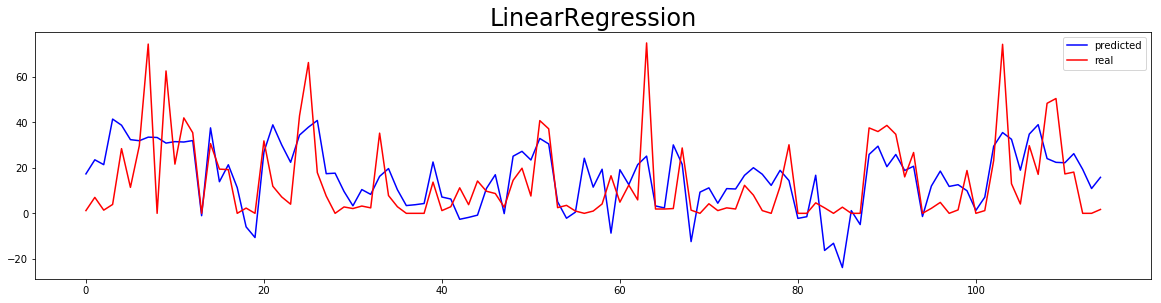

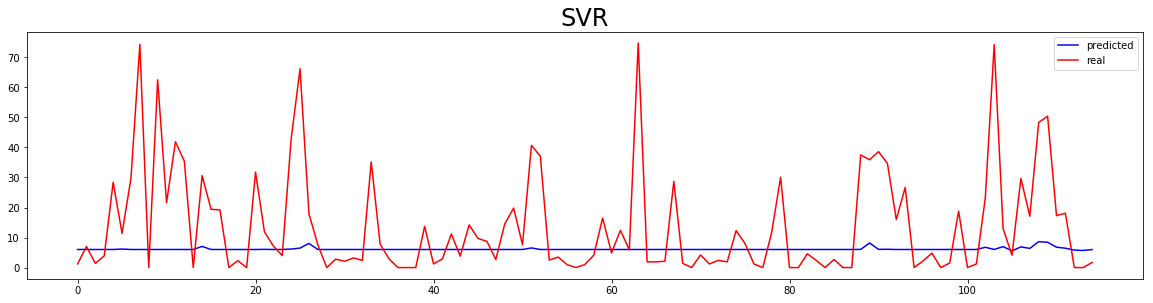

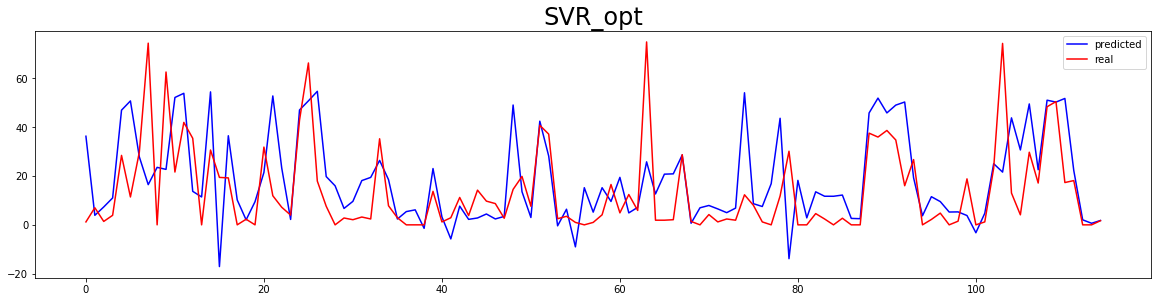

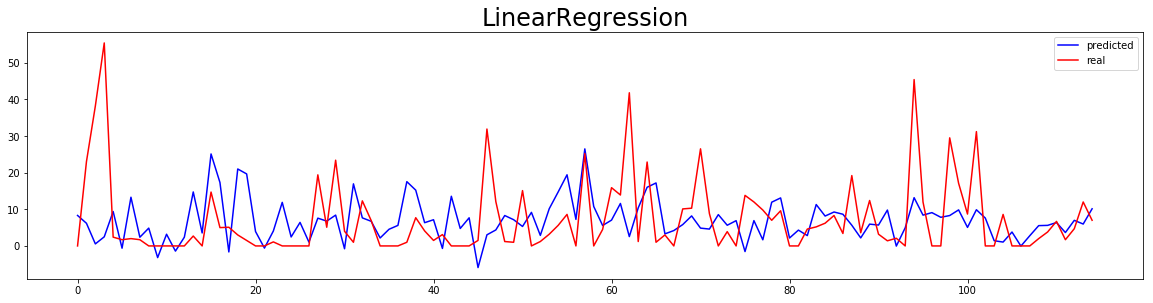

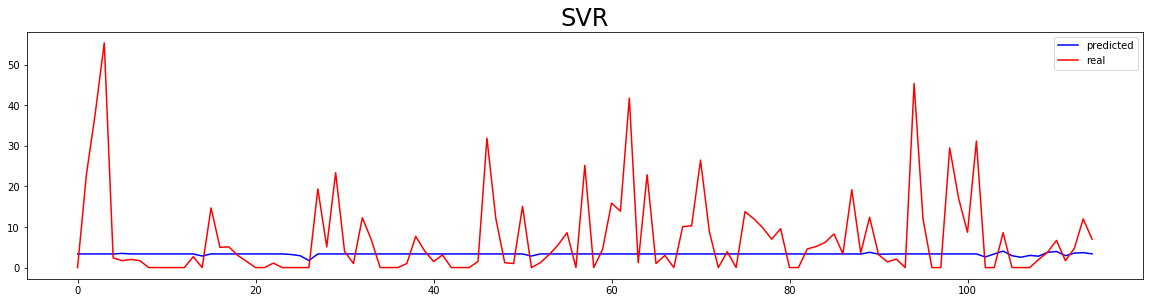

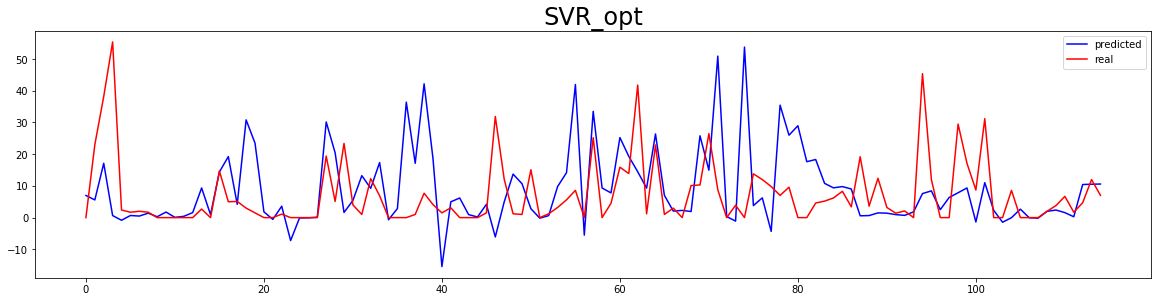

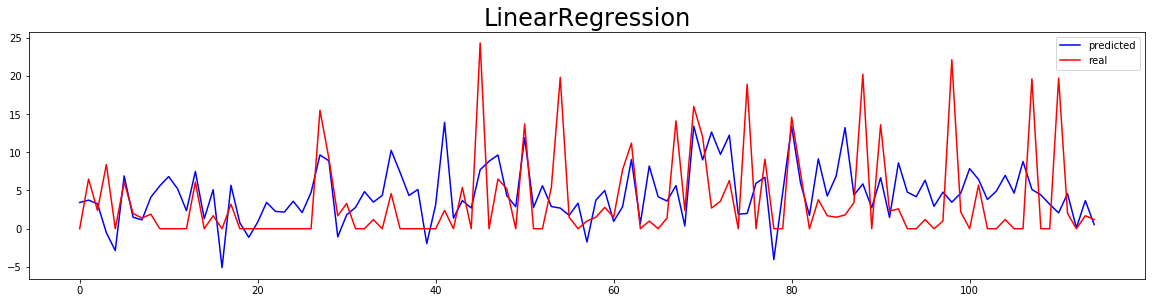

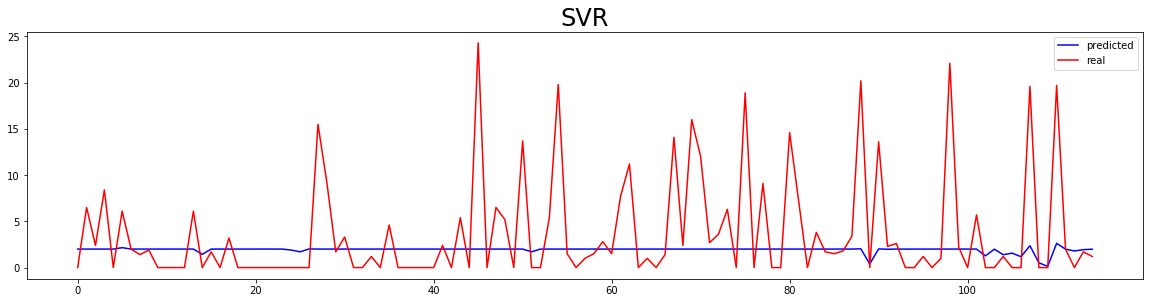

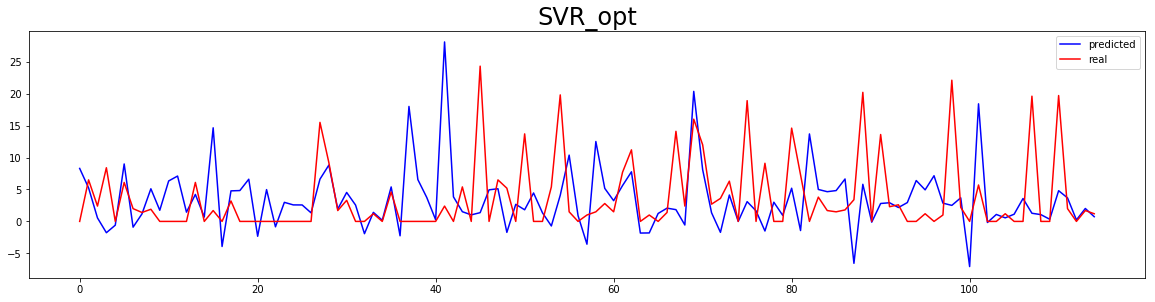

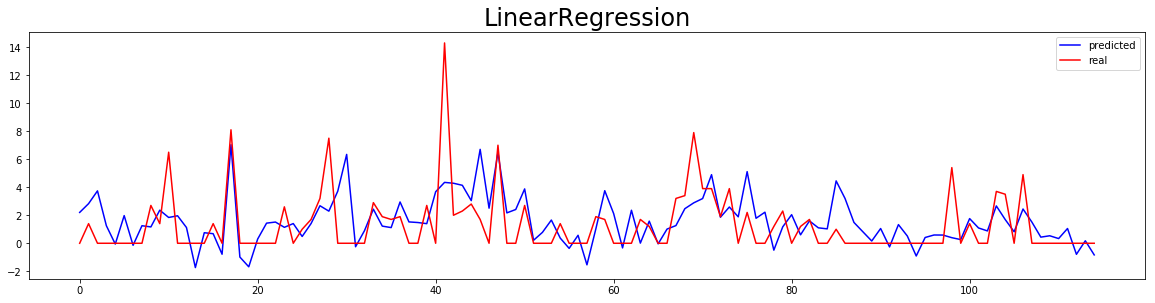

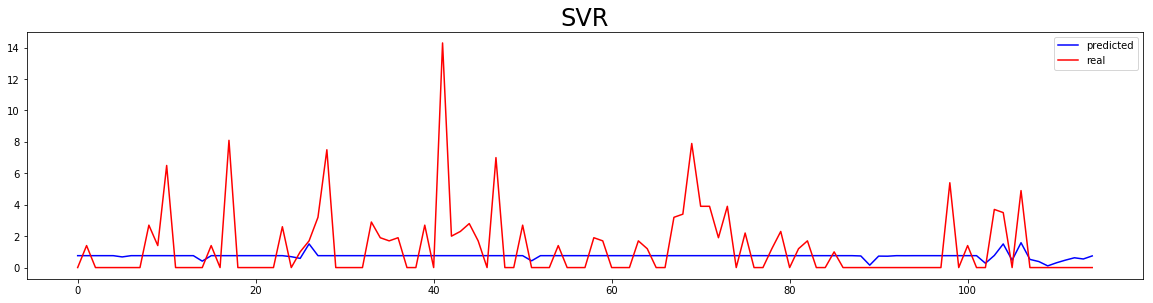

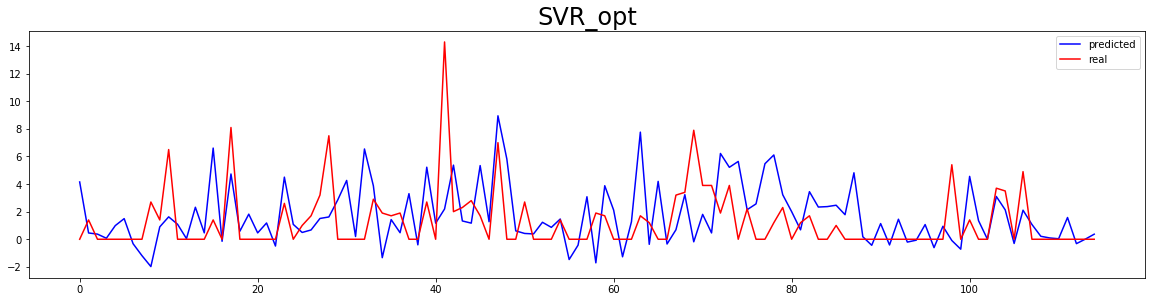

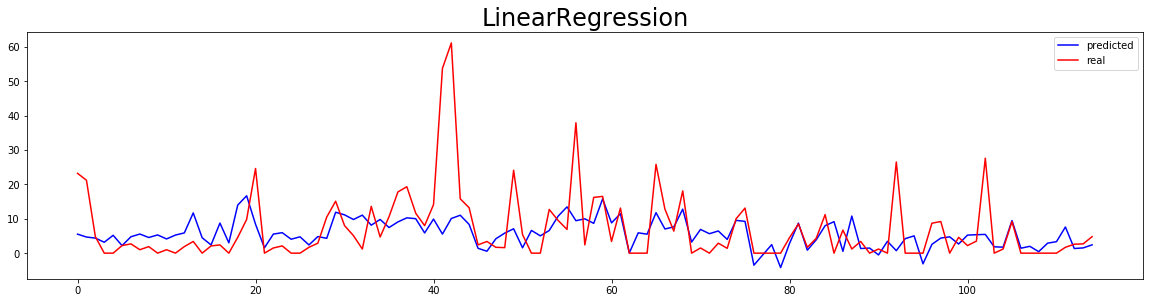

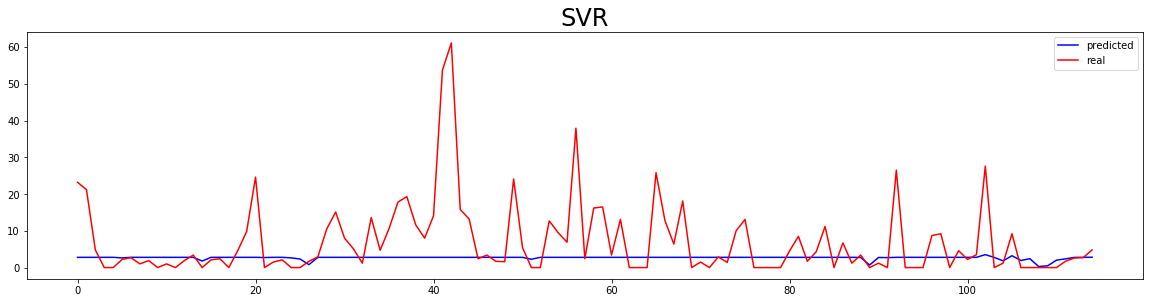

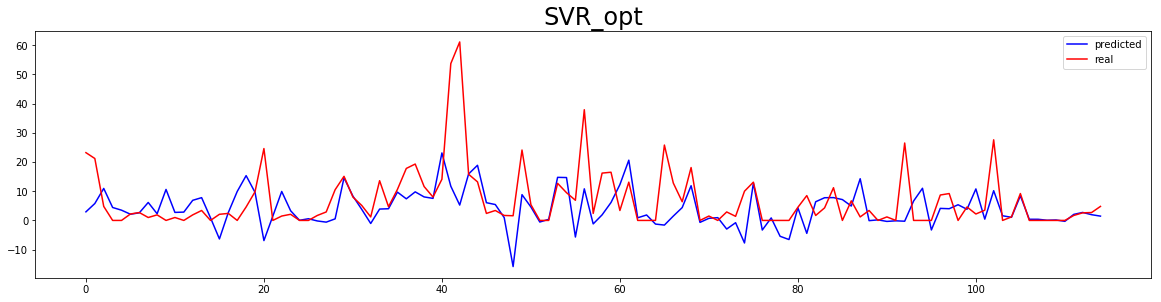

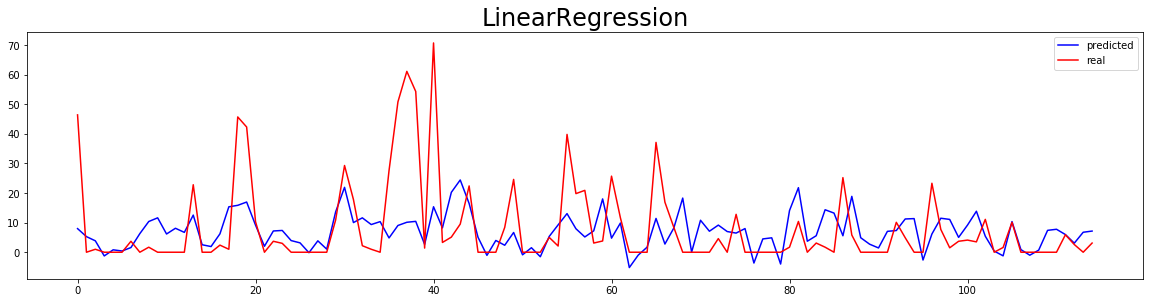

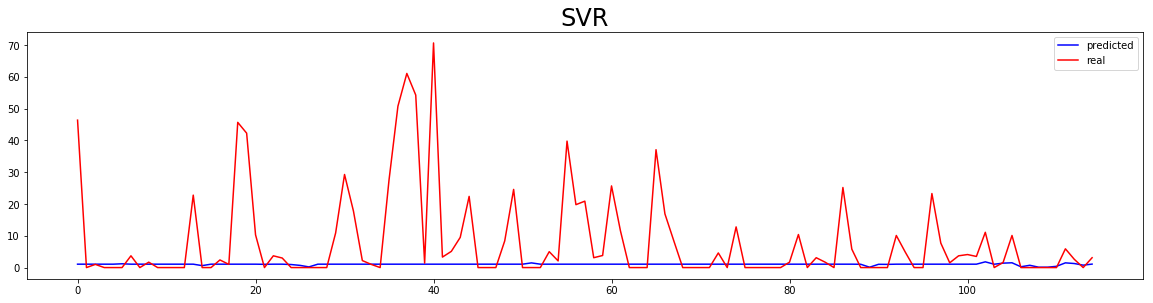

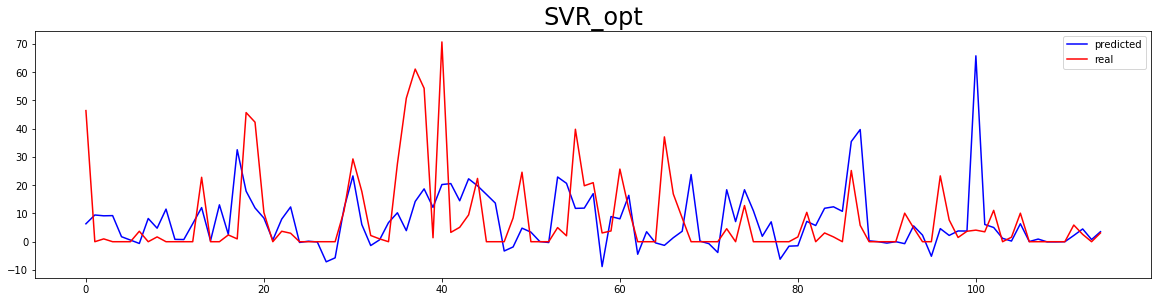

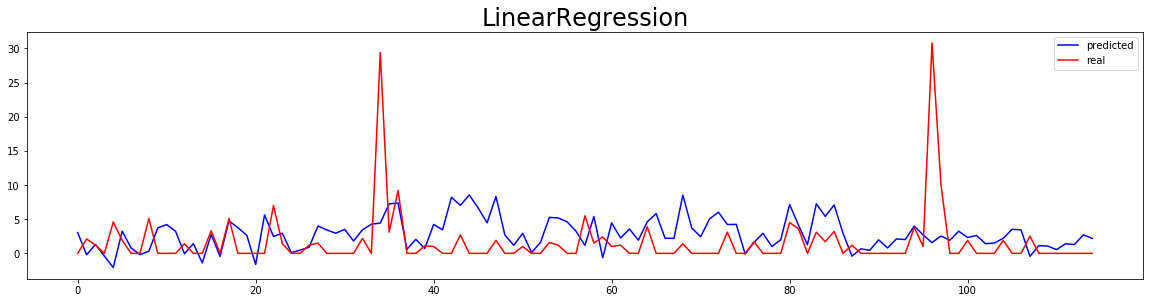

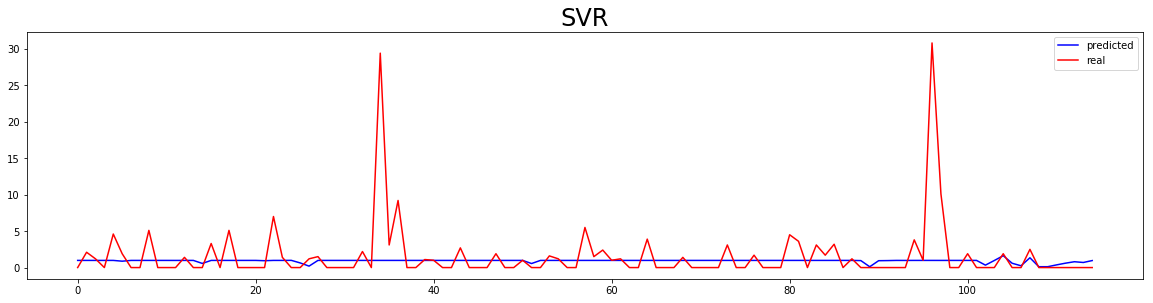

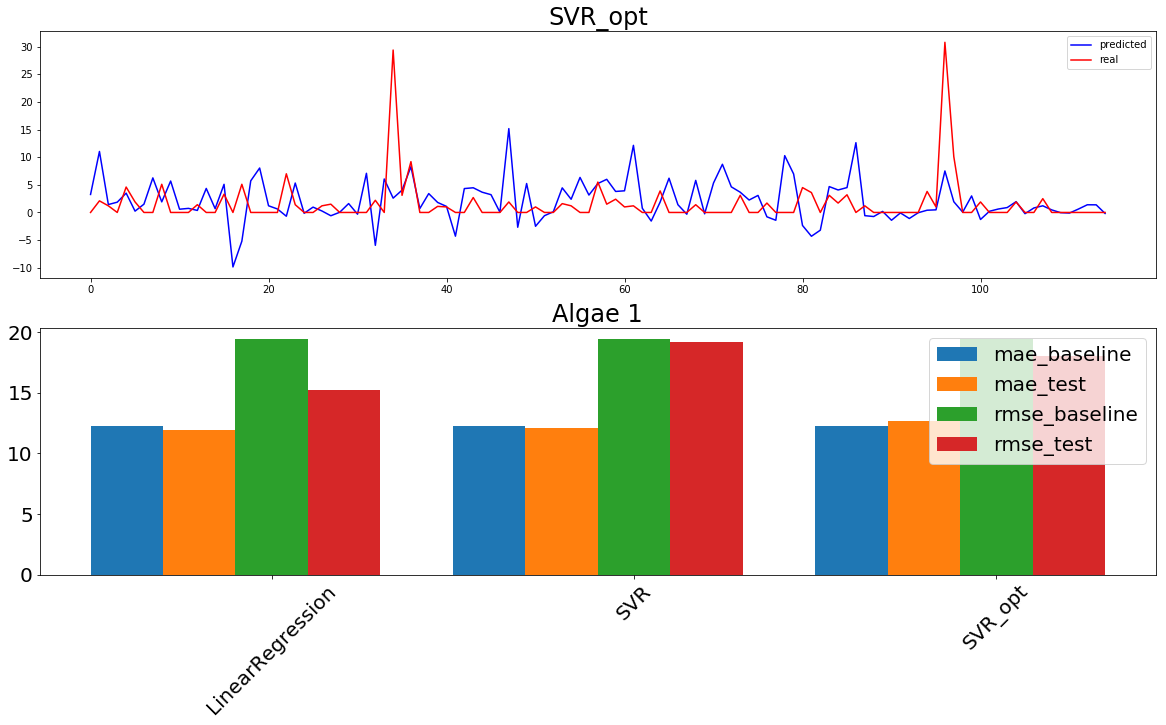

[0, 1, 2]
0.2
-0.2
0.0
0.2
0.4


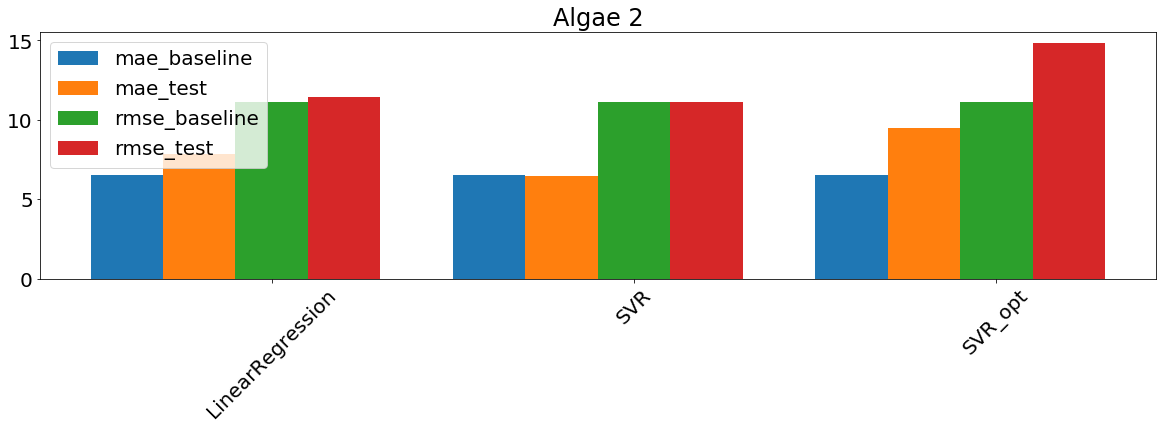

[0, 1, 2]
0.2
-0.2
0.0
0.2
0.4


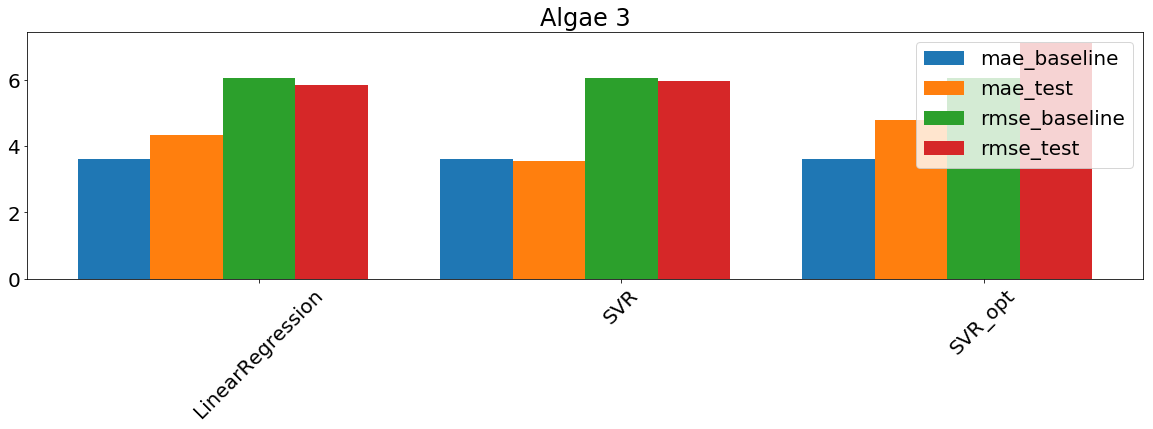

[0, 1, 2]
0.2
-0.2
0.0
0.2
0.4


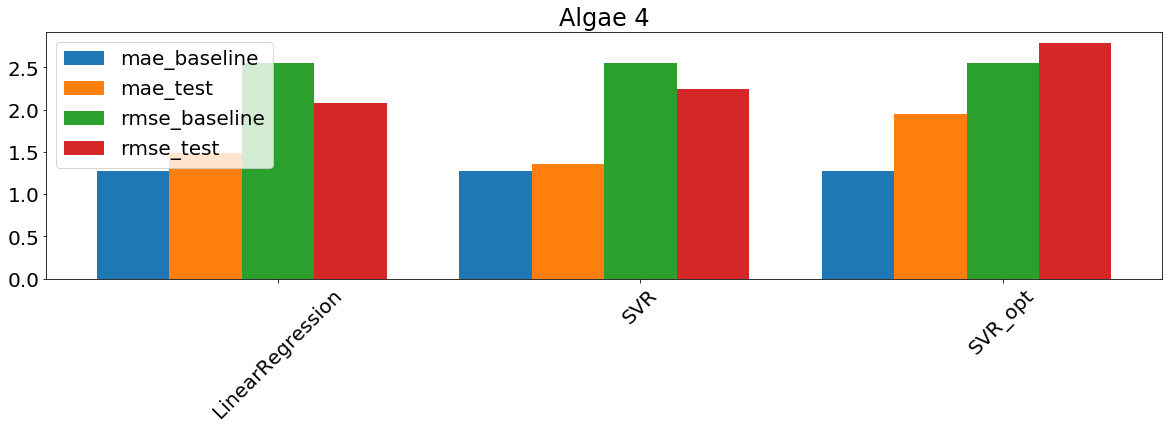

[0, 1, 2]
0.2
-0.2
0.0
0.2
0.4


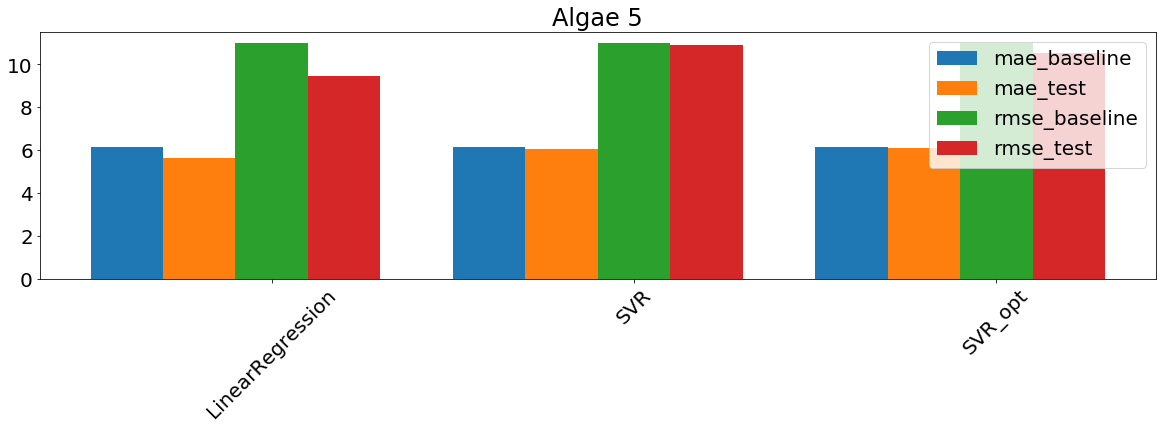

[0, 1, 2]
0.2
-0.2
0.0
0.2
0.4


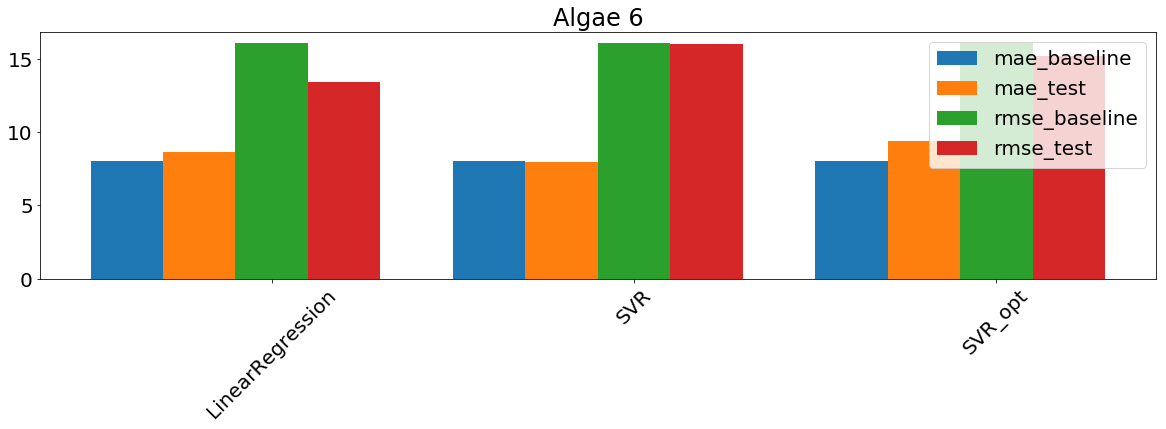

[0, 1, 2]
0.2
-0.2
0.0
0.2
0.4


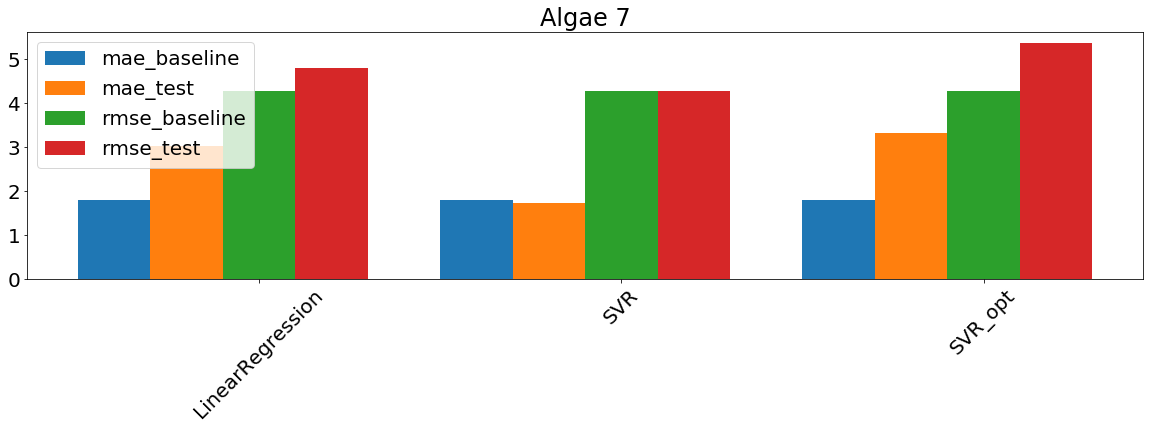

LinearRegression_mae_train_1	 12.278069436711823
LinearRegression_mae_test_1	 11.96096257398725
LinearRegression_mae_baseline_1	 12.239130434782611
LinearRegression_nmse_train_1	 0.587
LinearRegression_nmse_test_1	 0.53
LinearRegression_nmse_baseline_1	 0.183
LinearRegression_rmse_train_1	 16.15331046784145
LinearRegression_rmse_test_1	 15.26394276334286
LinearRegression_rmse_baseline_1	 19.39798958655252
LinearRegression_r2_train_1	 0.4002531727724008
LinearRegression_r2_test_1	 0.2586048557836994
LinearRegression_r2_baseline_1	 0.4002531727724008
SVR_mae_train_1	 13.361766203684
SVR_mae_test_1	 12.098235720717856
SVR_mae_baseline_1	 12.239130434782611
SVR_nmse_train_1	 0.18
SVR_nmse_test_1	 0.183
SVR_nmse_baseline_1	 0.183
SVR_rmse_train_1	 22.420401175774433
SVR_rmse_test_1	 19.152238717915417
SVR_rmse_baseline_1	 19.39798958655252
SVR_r2_train_1	 -0.15539806828590264
SVR_r2_test_1	 -0.1672271265324703
SVR_r2_baseline_1	 -0.15539806828590264
SVR_opt_mae_train_1	 5.3316984971162515
S

In [199]:
models = {'LinearRegression' : 'LinearRegression()',
          'SVR' : 'SVR()',
          'SVR_opt' : 'SVR(kernel="rbf", C=500, gamma=.0001)',  
         }

test_models()
for k , v in results.items(): # iterating freqa dictionary
        print(k+"\t", v)

## Let's test some models , without tuning hyperparameters of SVR model

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


tuned mod = SVR(C=10, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma=0.0001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Fitting 4 folds for each of 25 candidates, totalling 100 fits
tuned mod = SVR(C=10, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma=0.0001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


tuned mod = SVR(C=10, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma=0.0001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


tuned mod = SVR(C=10, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma=0.0001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


tuned mod = SVR(C=10, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma=0.0001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


tuned mod = SVR(C=10, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


tuned mod = SVR(C=10, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[0, 1, 2, 3]
0.2
-0.2
0.0
0.2
0.4


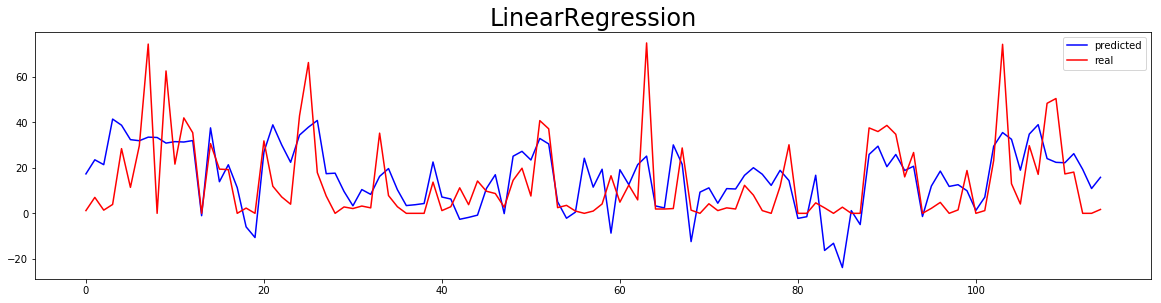

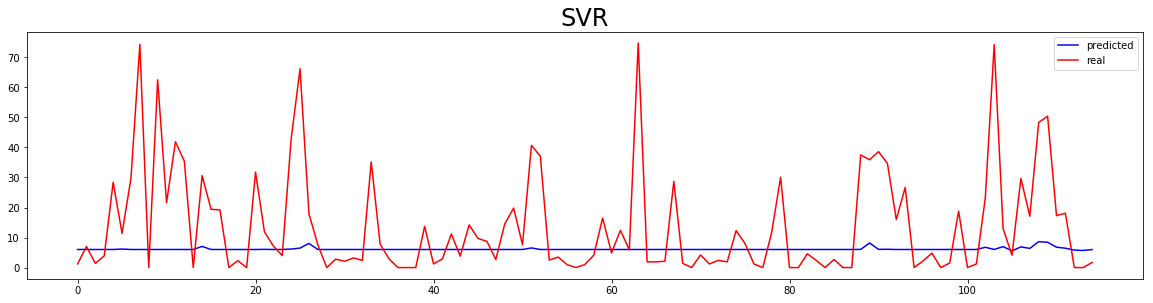

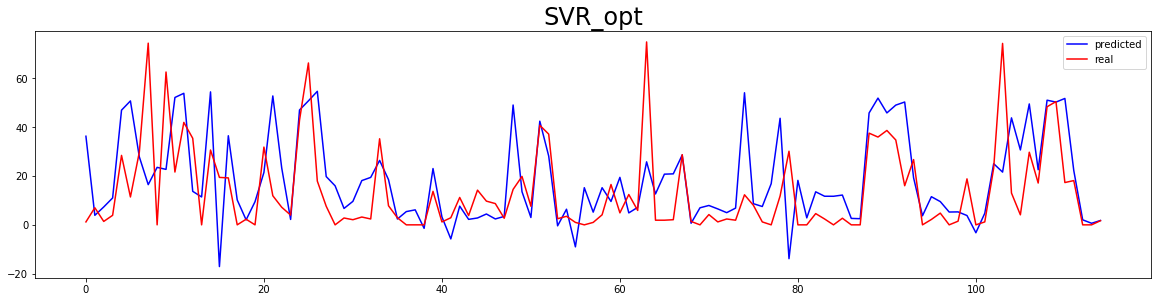

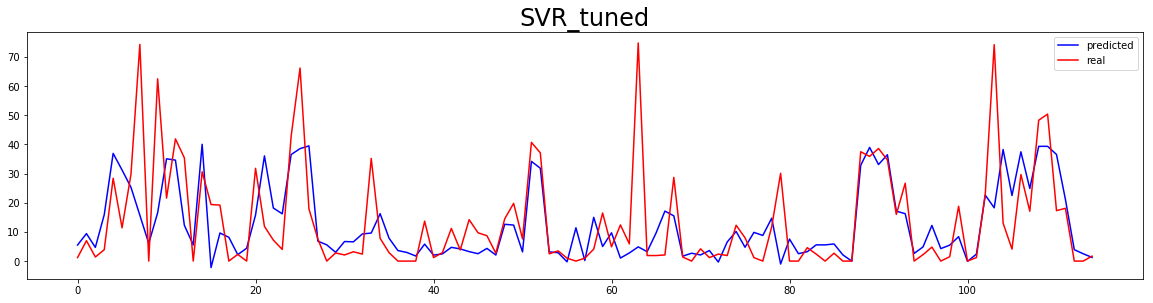

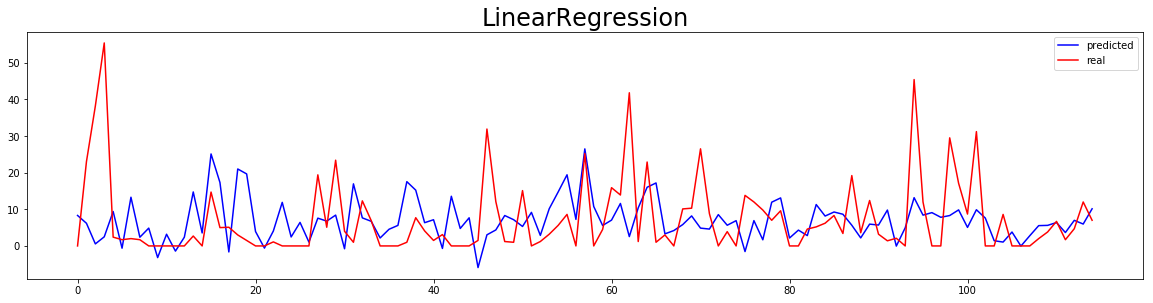

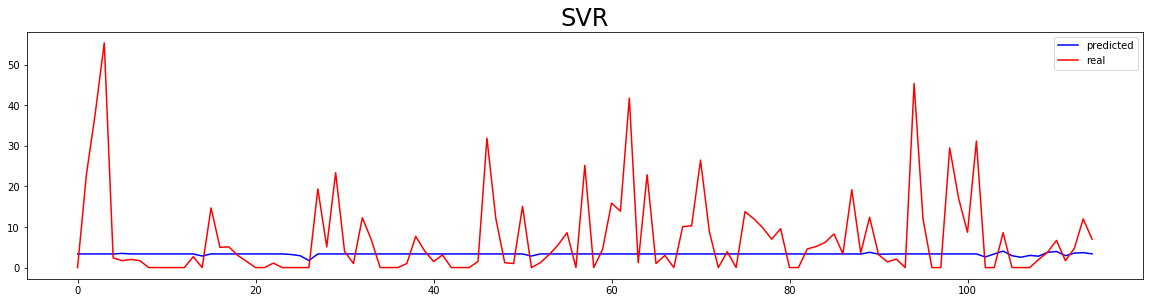

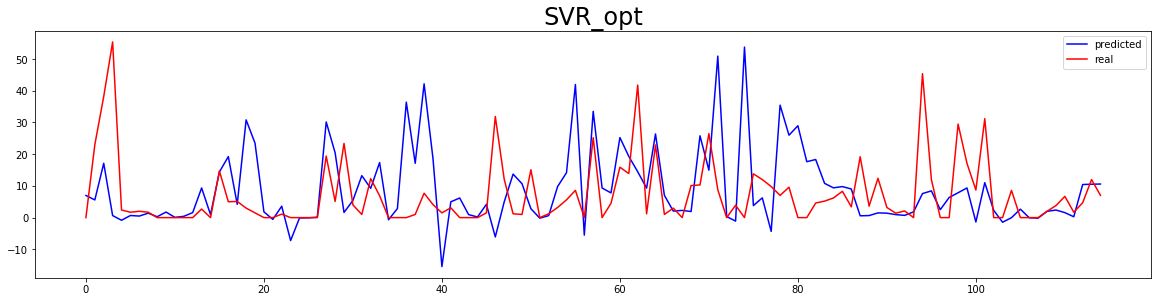

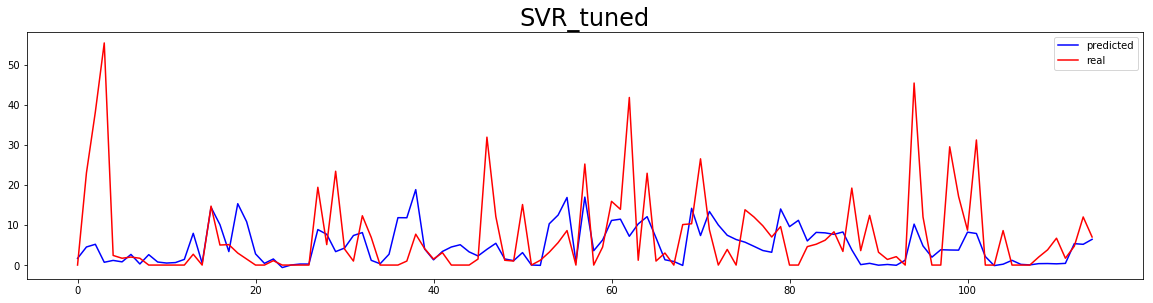

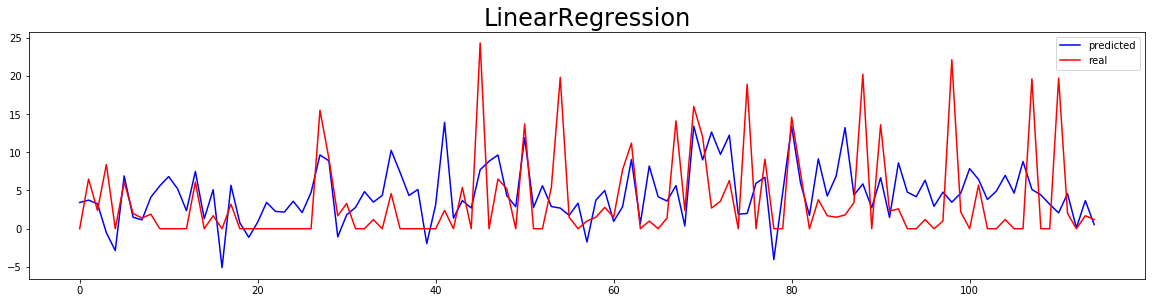

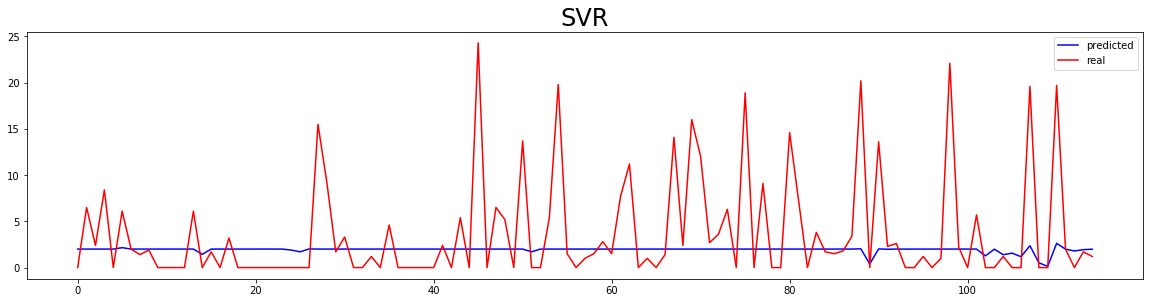

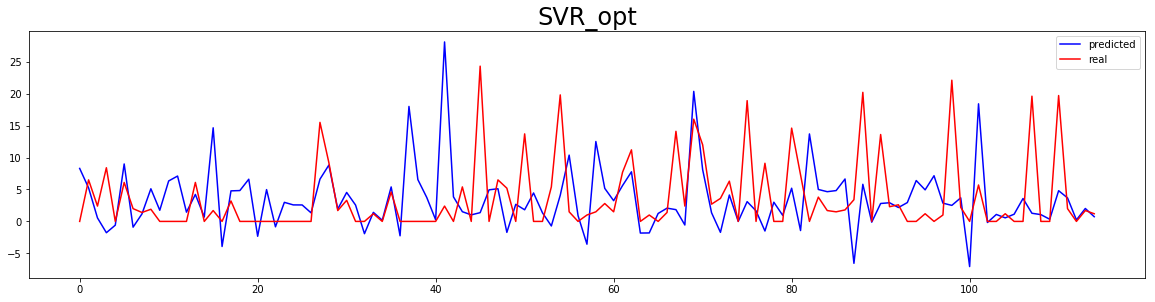

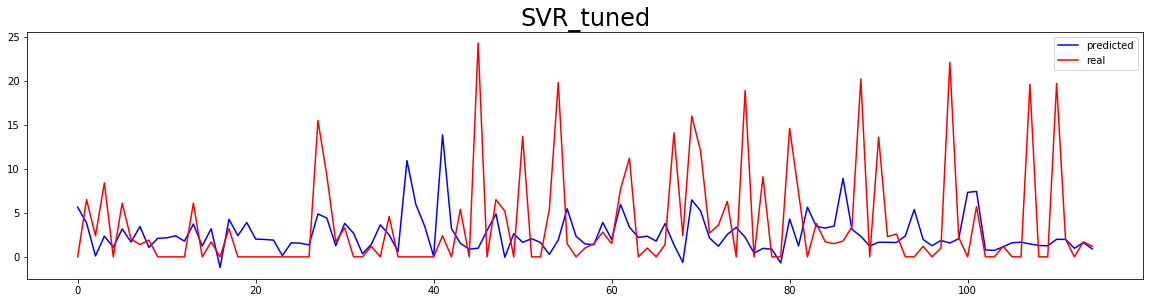

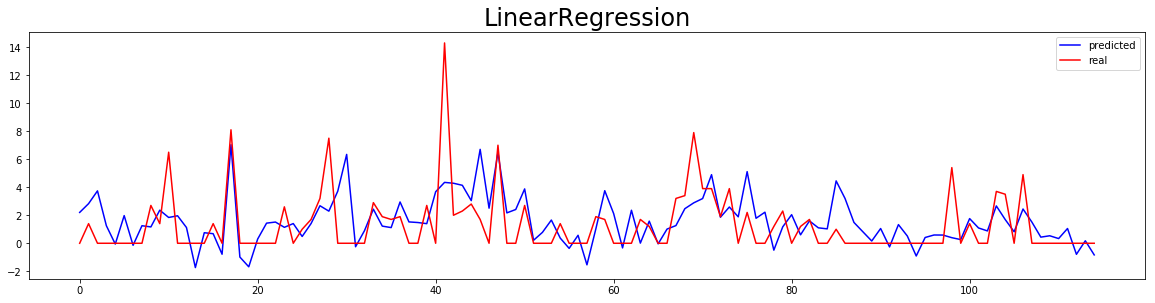

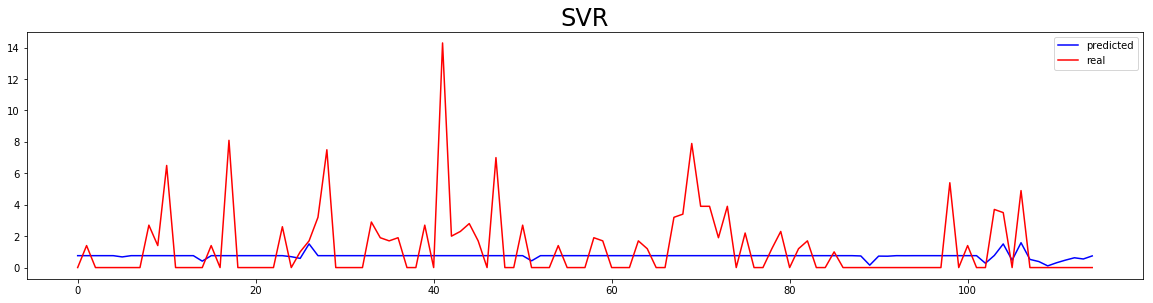

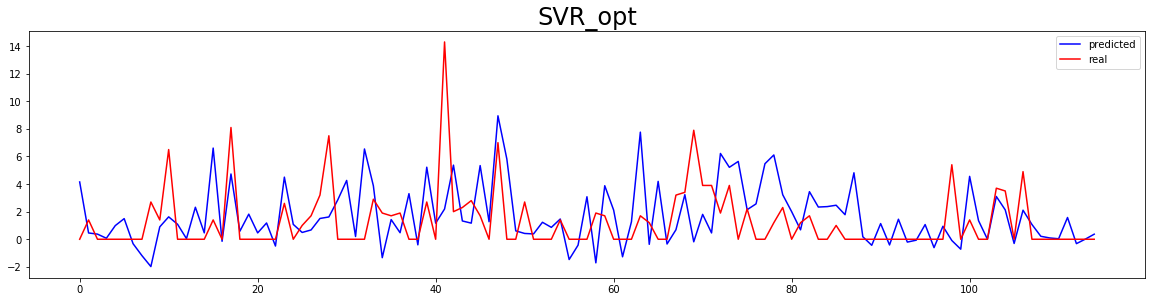

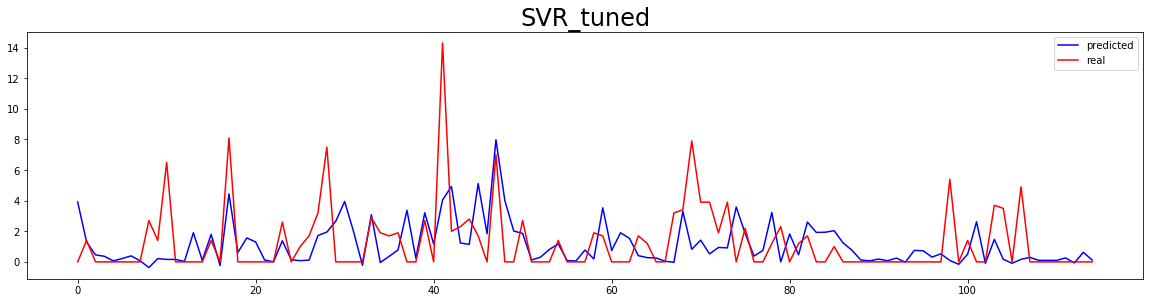

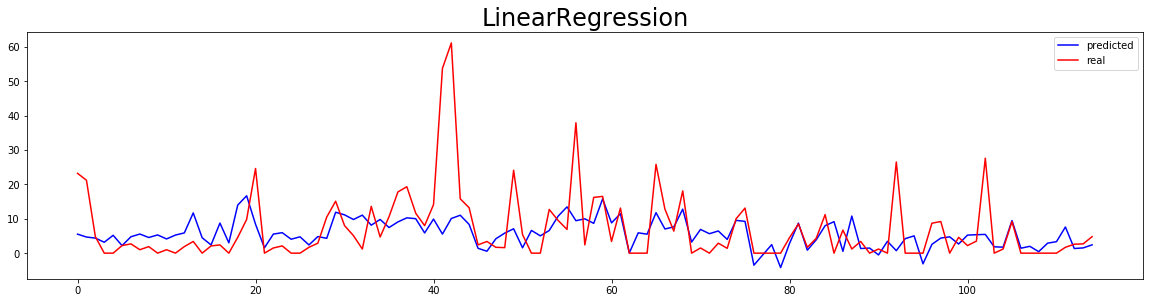

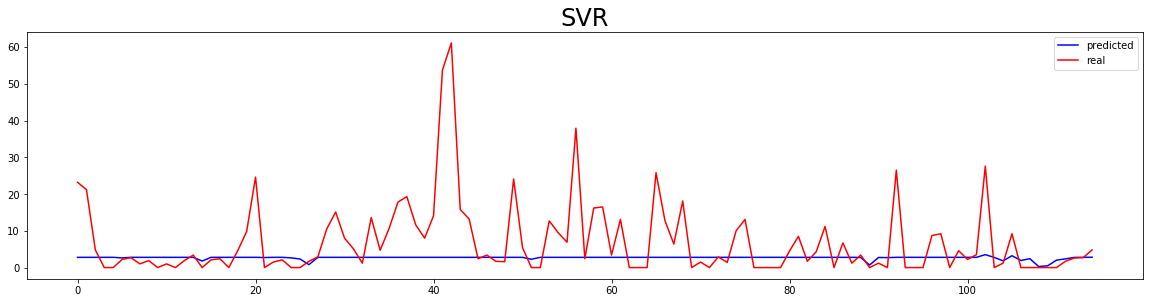

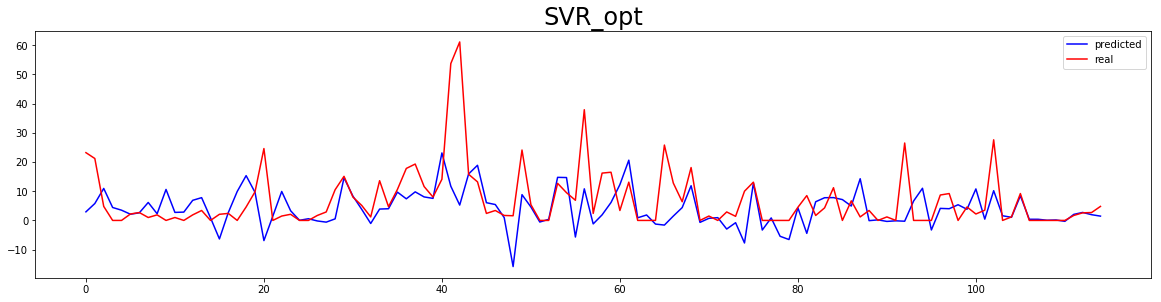

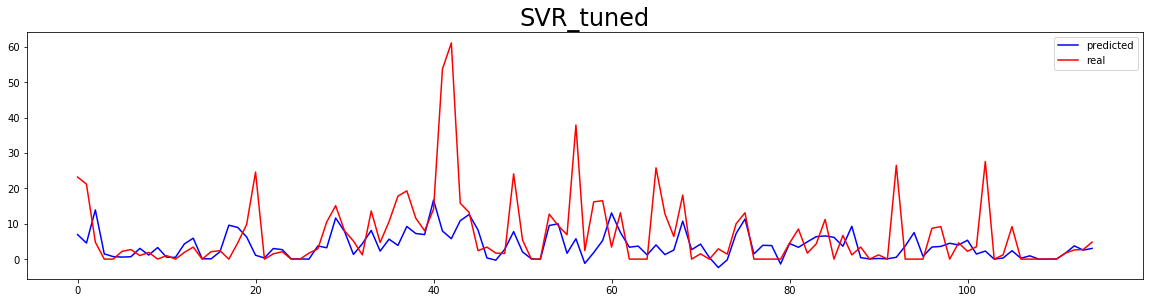

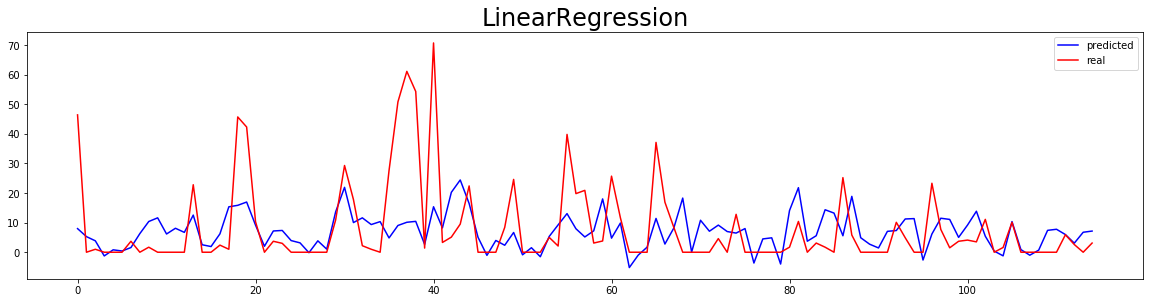

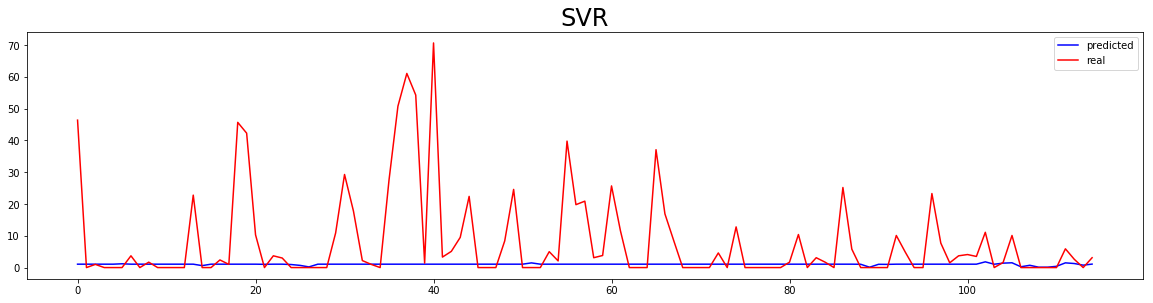

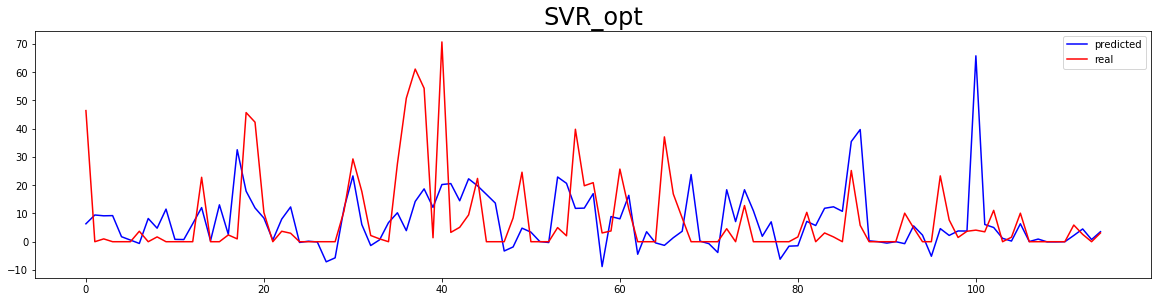

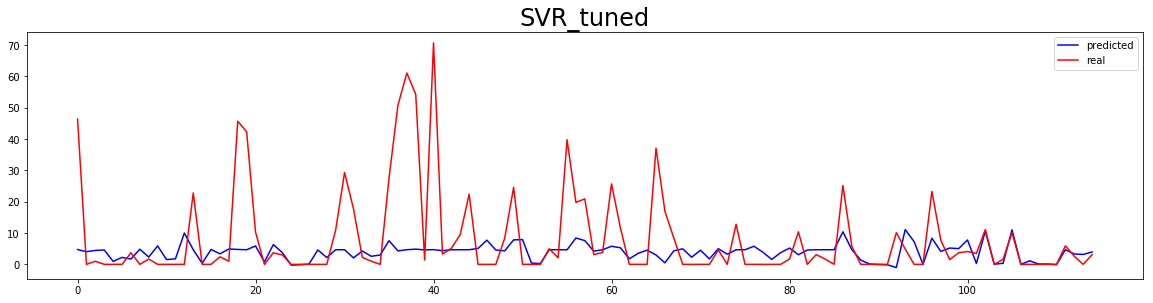

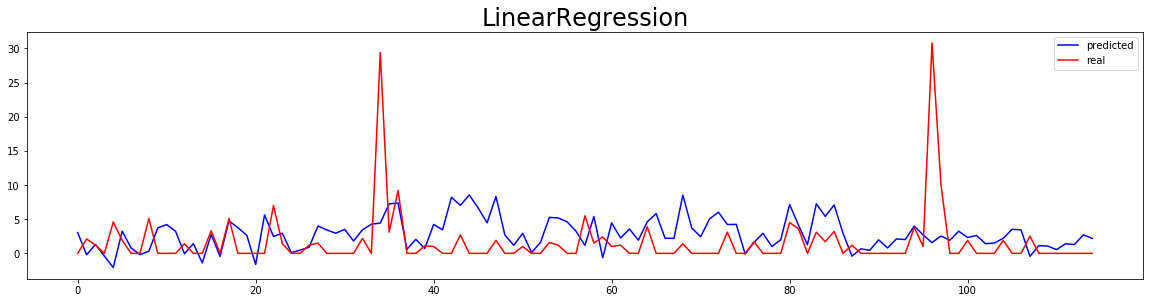

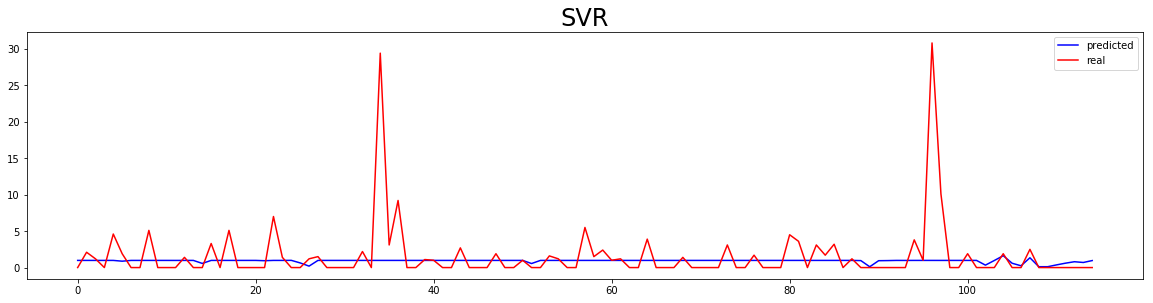

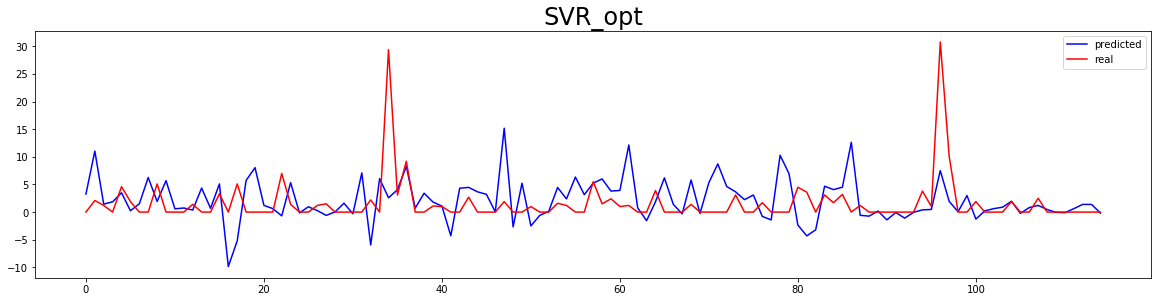

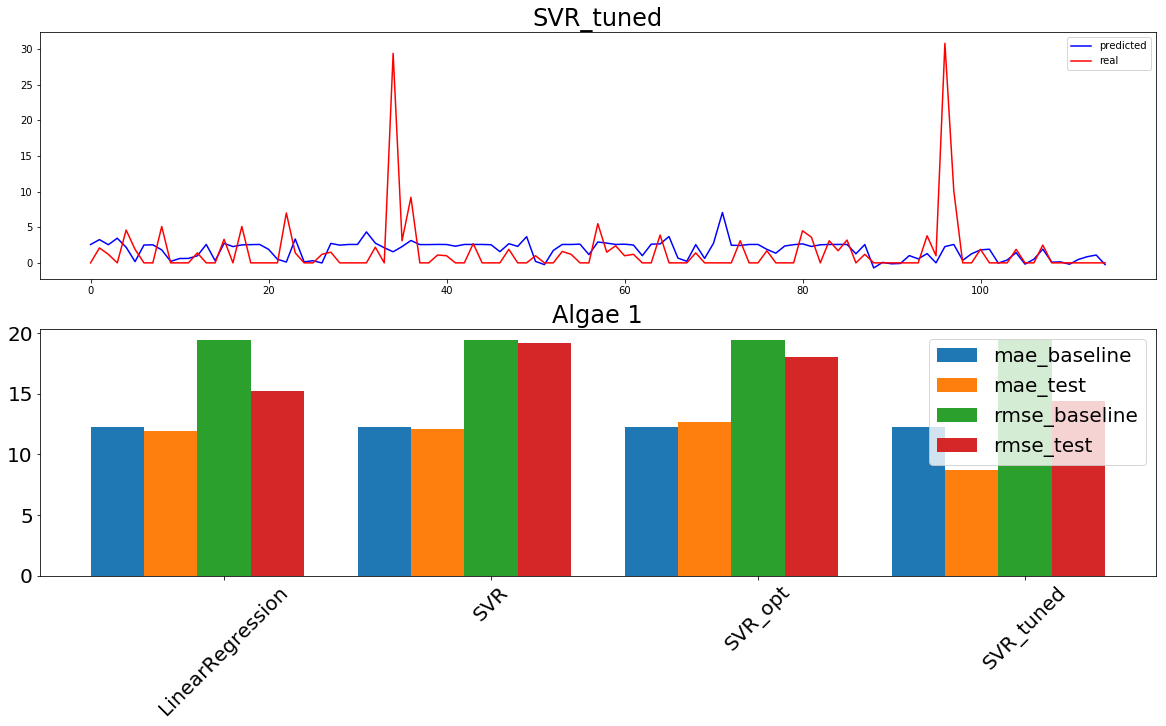

[0, 1, 2, 3]
0.2
-0.2
0.0
0.2
0.4


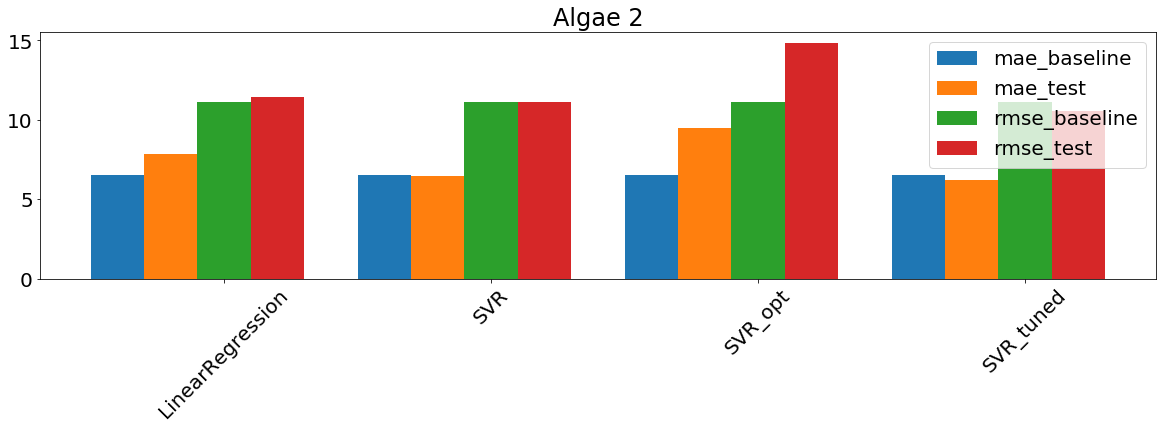

[0, 1, 2, 3]
0.2
-0.2
0.0
0.2
0.4


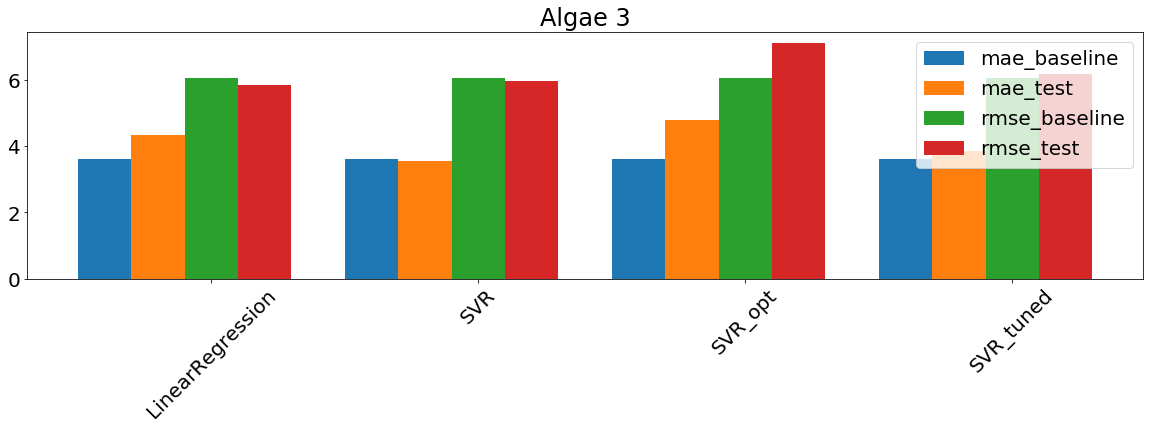

[0, 1, 2, 3]
0.2
-0.2
0.0
0.2
0.4


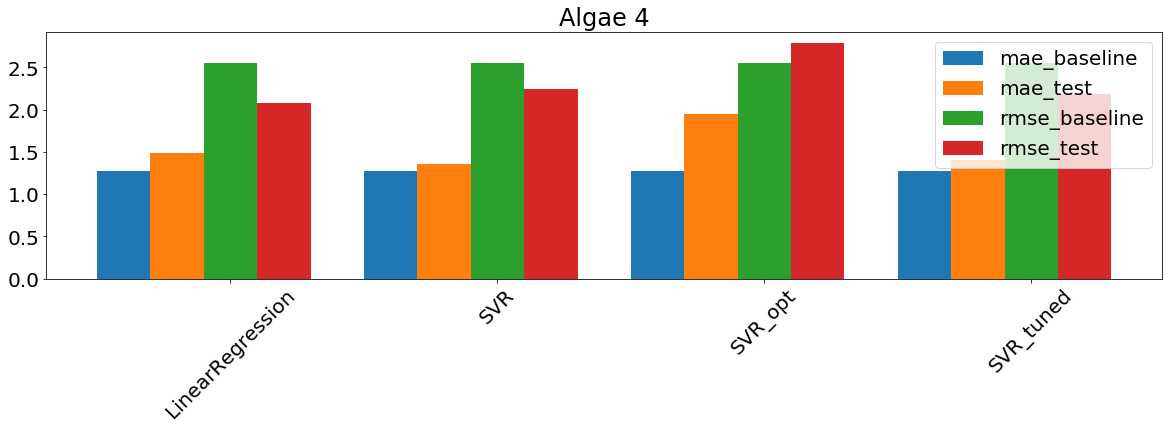

[0, 1, 2, 3]
0.2
-0.2
0.0
0.2
0.4


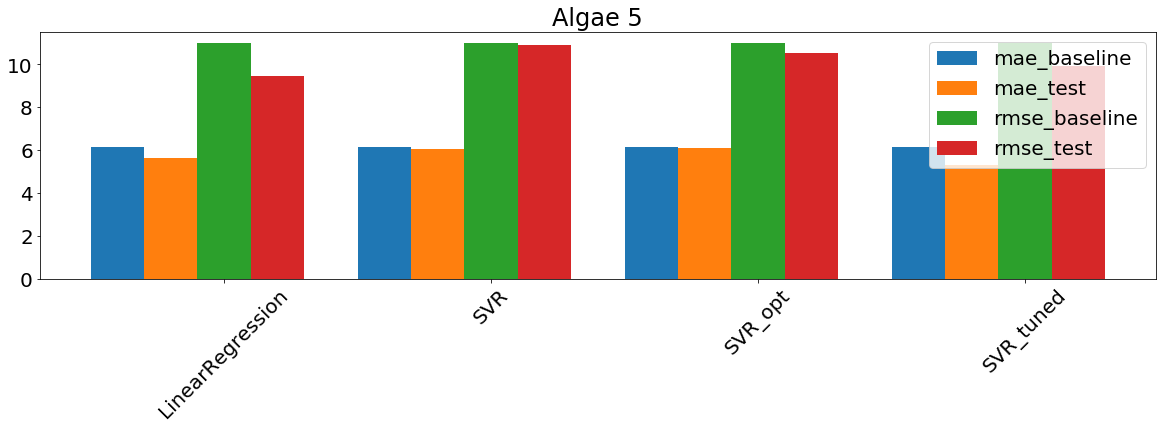

[0, 1, 2, 3]
0.2
-0.2
0.0
0.2
0.4


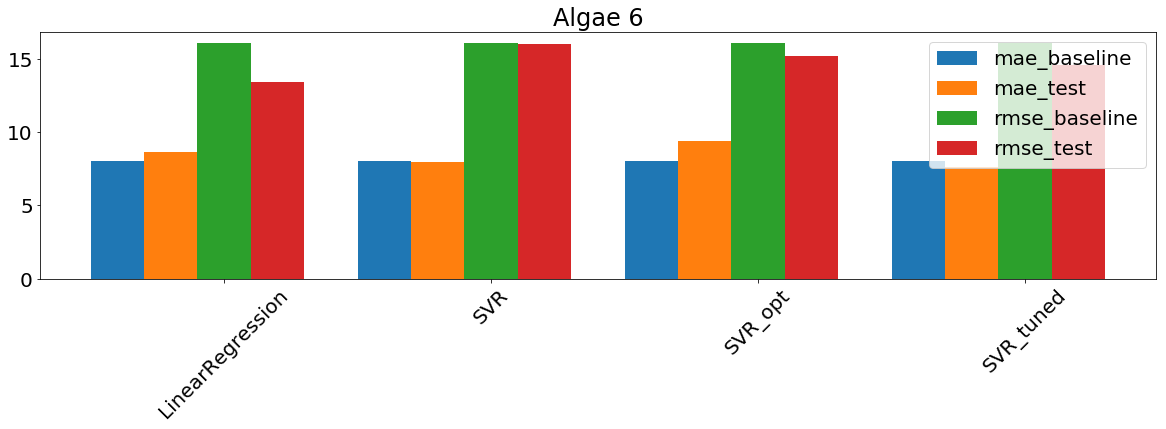

[0, 1, 2, 3]
0.2
-0.2
0.0
0.2
0.4


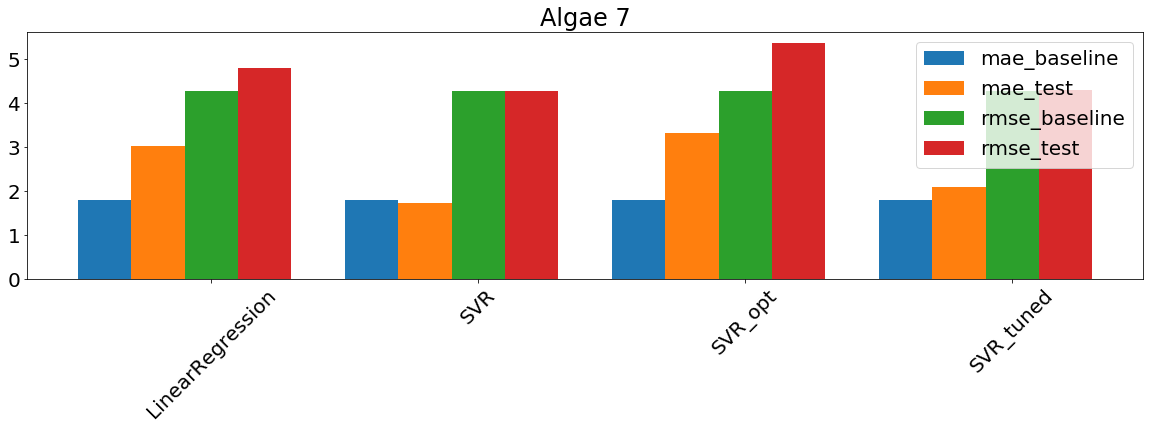

In [200]:
# A list for each input arguments to SVR model function 
#kernel = ['linear', 'poly']#, 'rbf', 'sigmoid']

# Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
gamma = [0.0001, 0.001, 0.1]

degree = [1, 2, 3]#, 4, 5]

# Penalty parameter C of the error term.
C = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


# Define the grid of hyperparameters to search
hyperparameter_grid = {
                       #'kernel': kernel,
                       'gamma': gamma,
                       'degree':degree,
                       'C': C
                      }

# Create the model to use for hyperparameter tuning
model = SVR(kernel = 'rbf')

# THIS STEP MAY TAKE SOME TIME TO RUN
# Tune hyperparameters of model, add to results dictionary and plot
test_models(hyperparam_tune=True, 
            tune_model=model,
            tune_model_name='SVR_tuned',
            hyperparameter_grid=hyperparameter_grid)

## Let's test some models , this time linear regression is omitted from dict of models to test

[0, 1]
0.4
0.10000000000000003
0.5


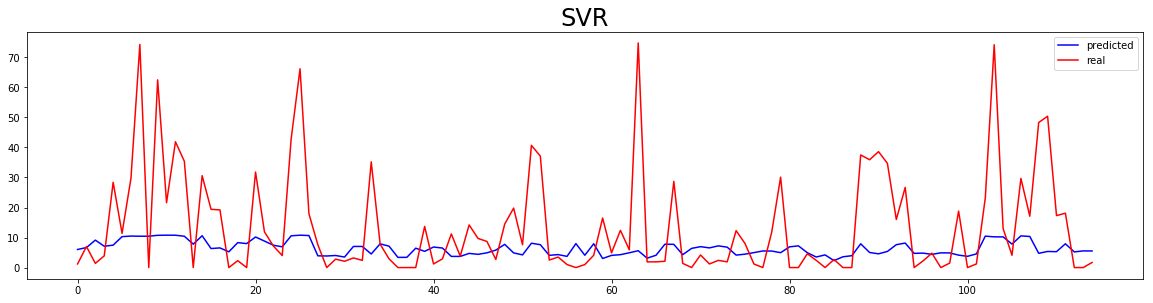

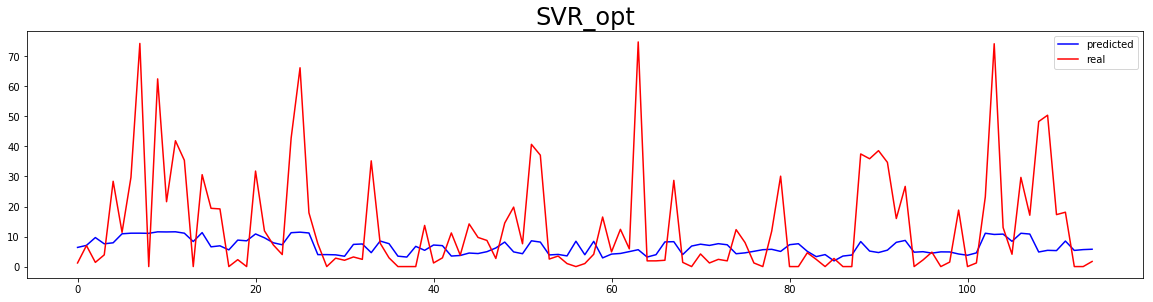

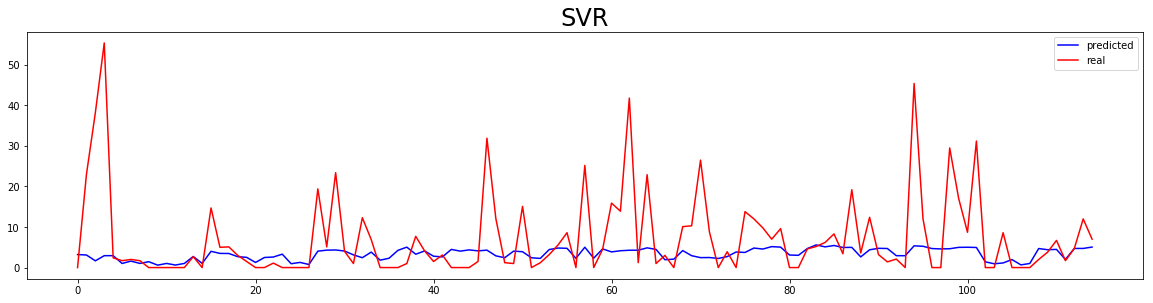

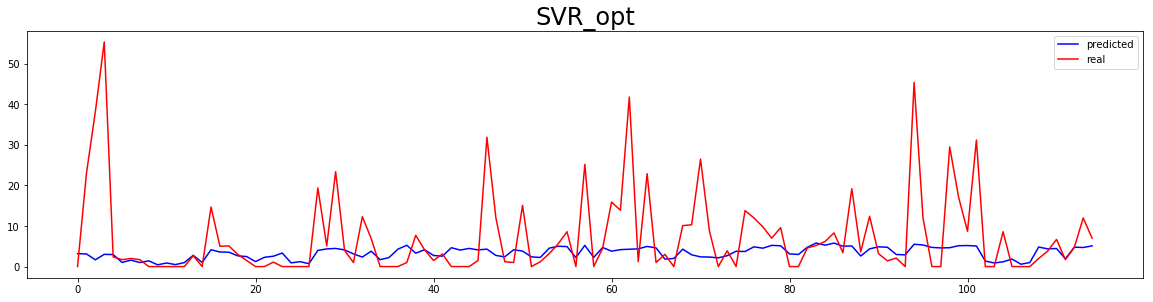

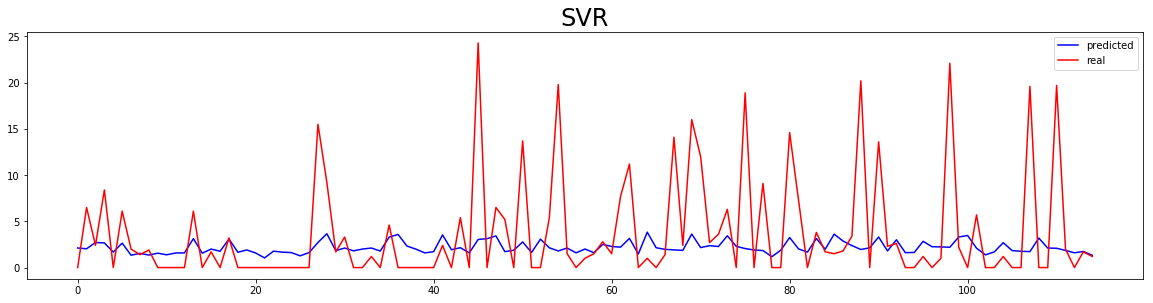

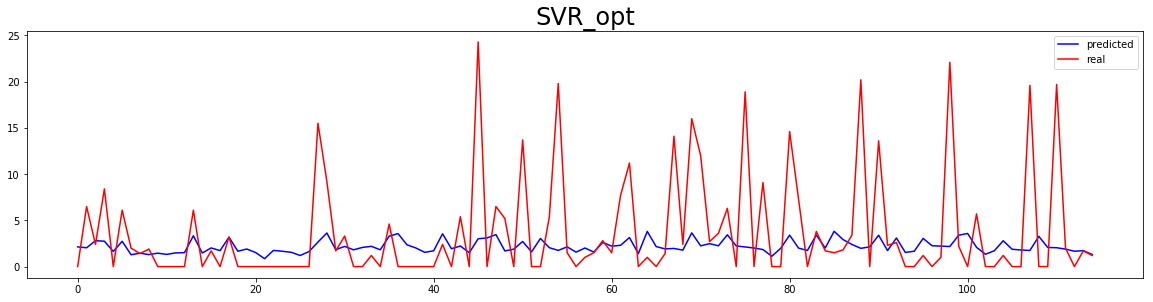

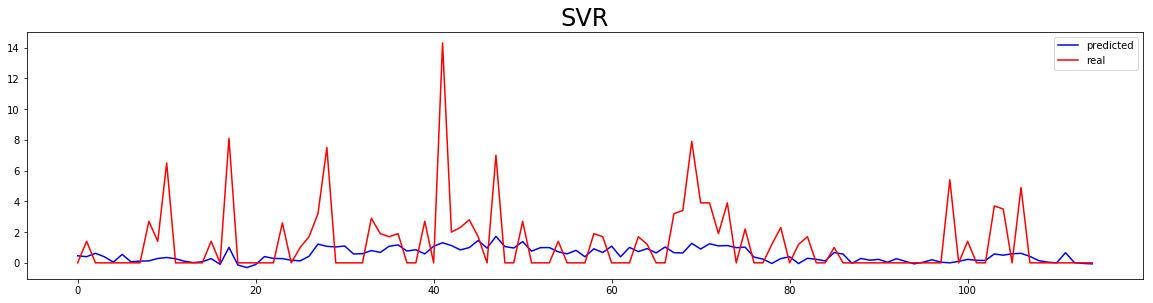

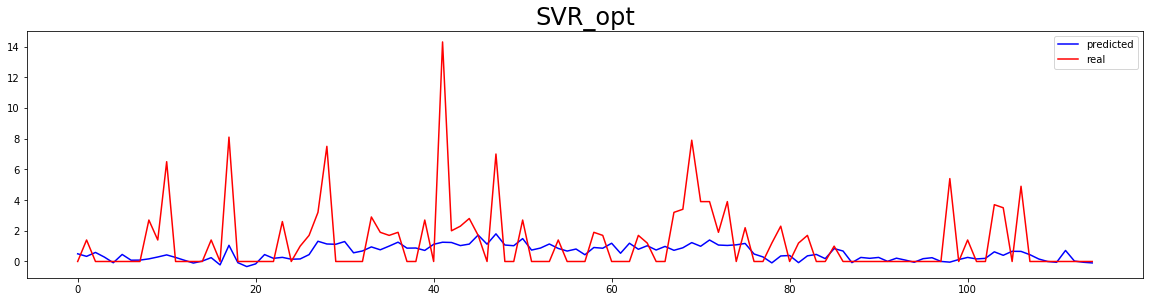

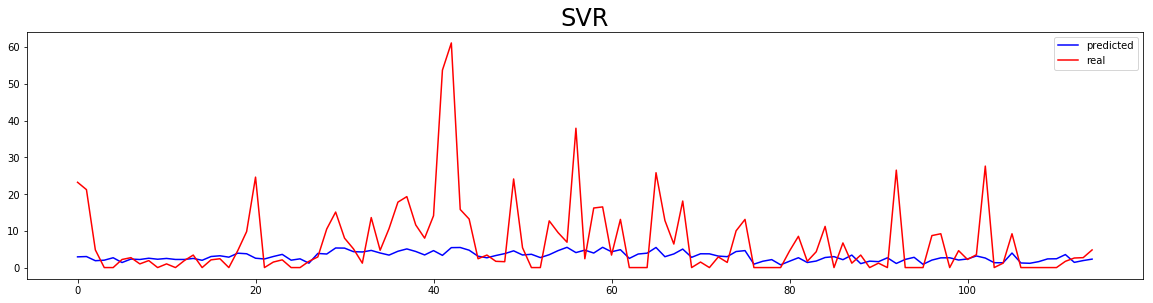

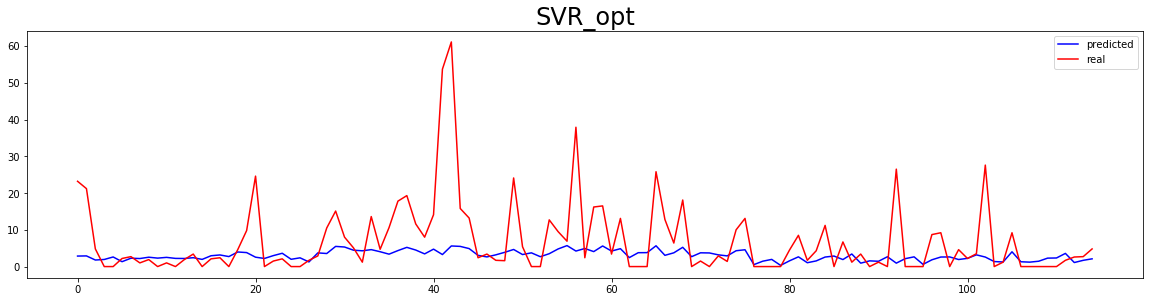

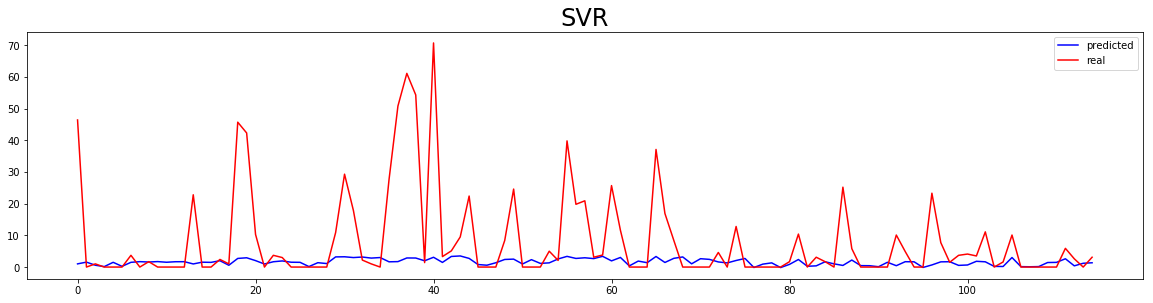

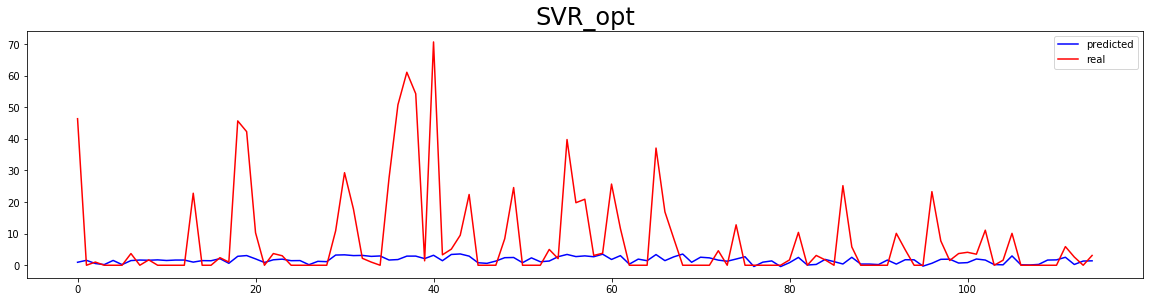

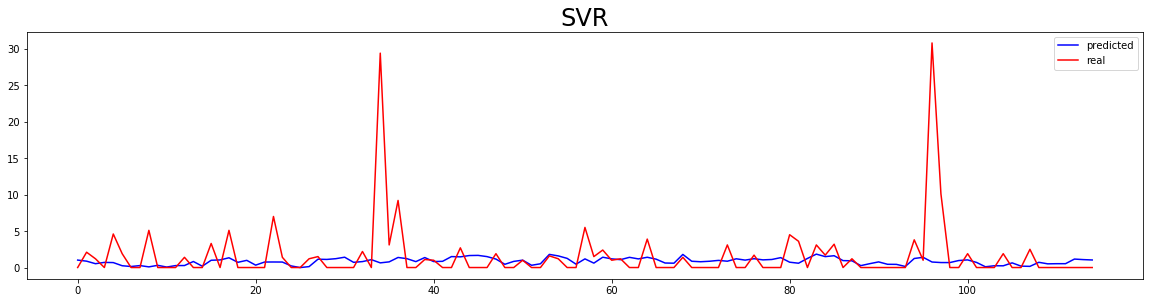

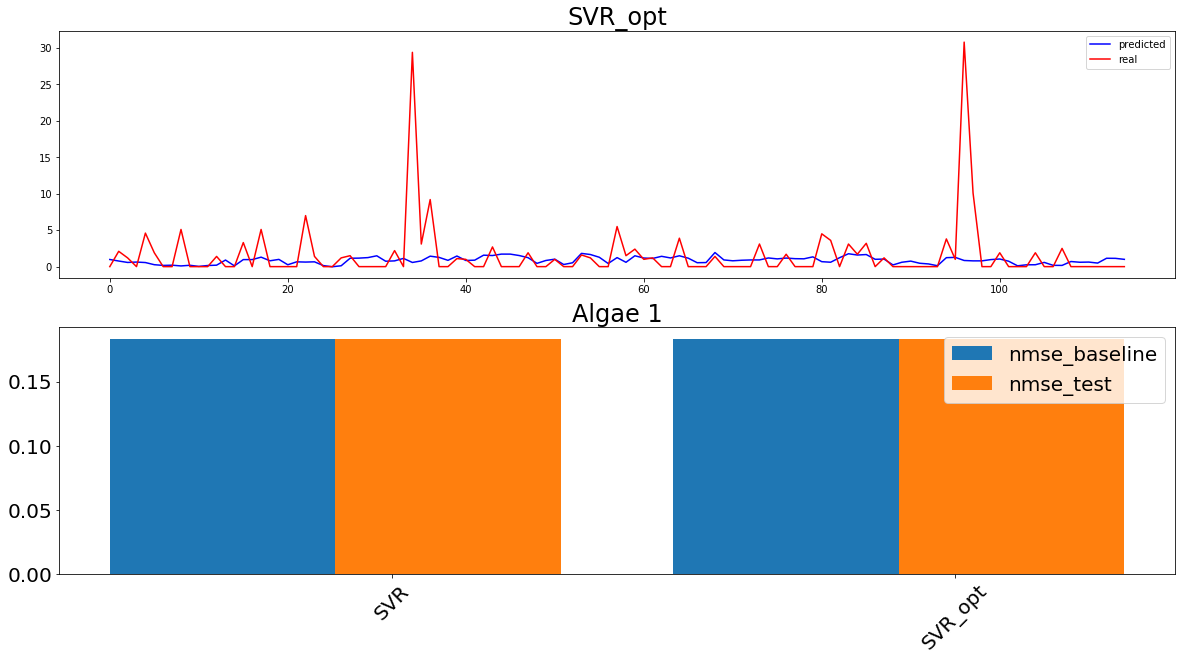

[0, 1]
0.4
0.10000000000000003
0.5


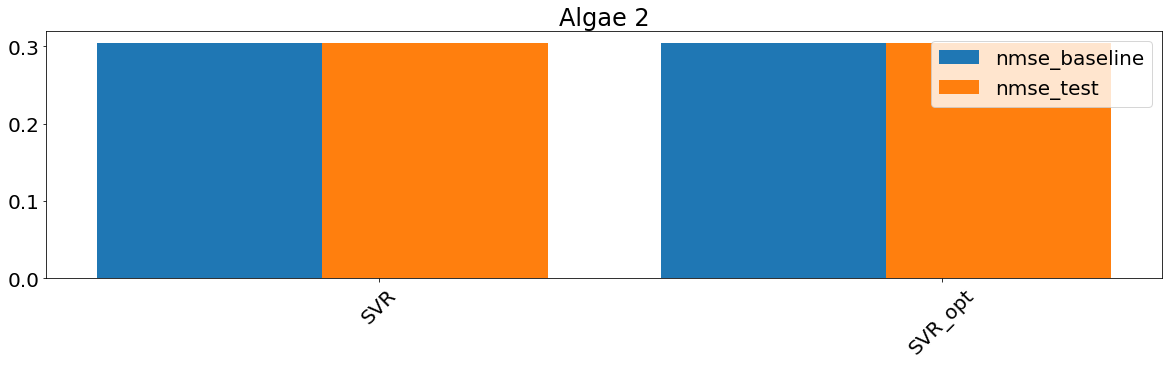

[0, 1]
0.4
0.10000000000000003
0.5


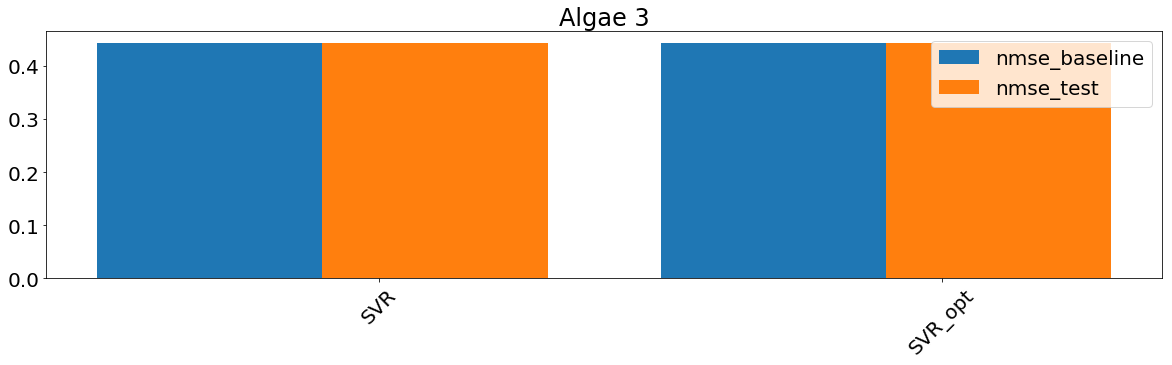

[0, 1]
0.4
0.10000000000000003
0.5


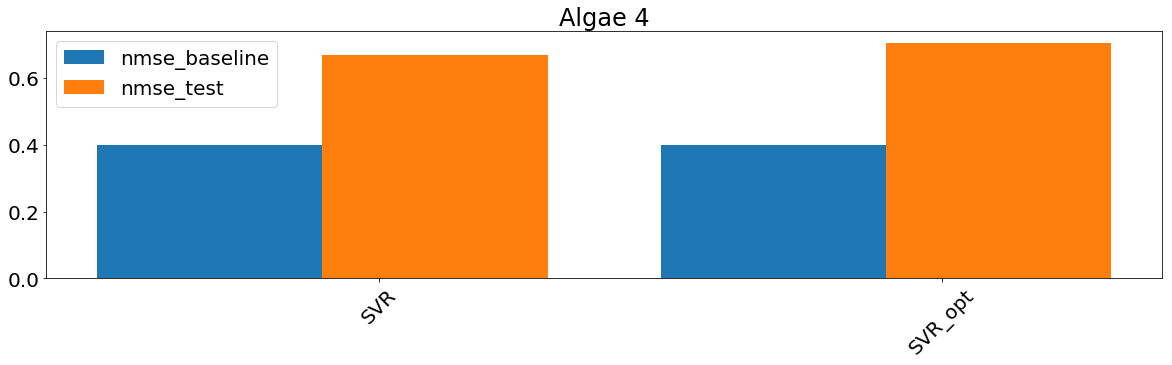

[0, 1]
0.4
0.10000000000000003
0.5


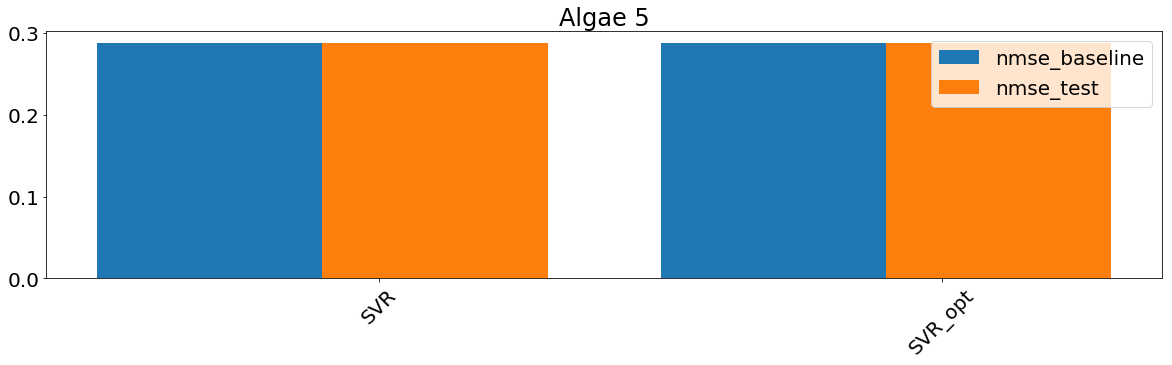

[0, 1]
0.4
0.10000000000000003
0.5


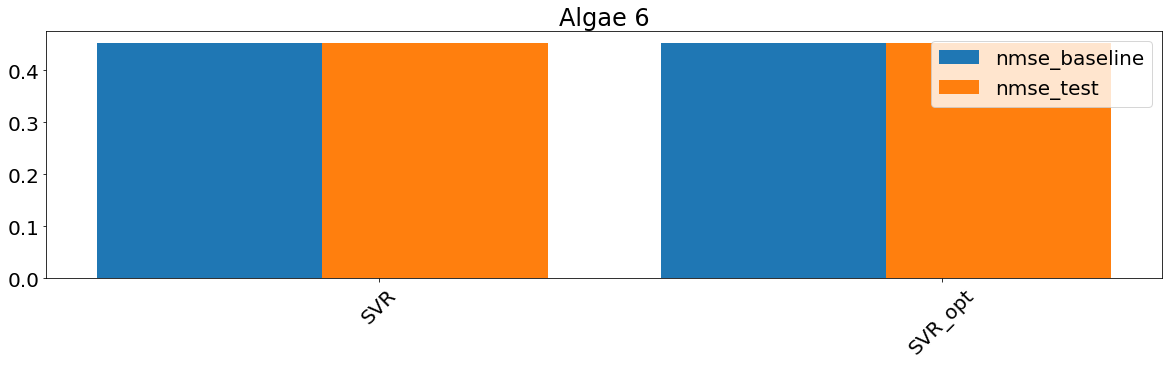

[0, 1]
0.4
0.10000000000000003
0.5


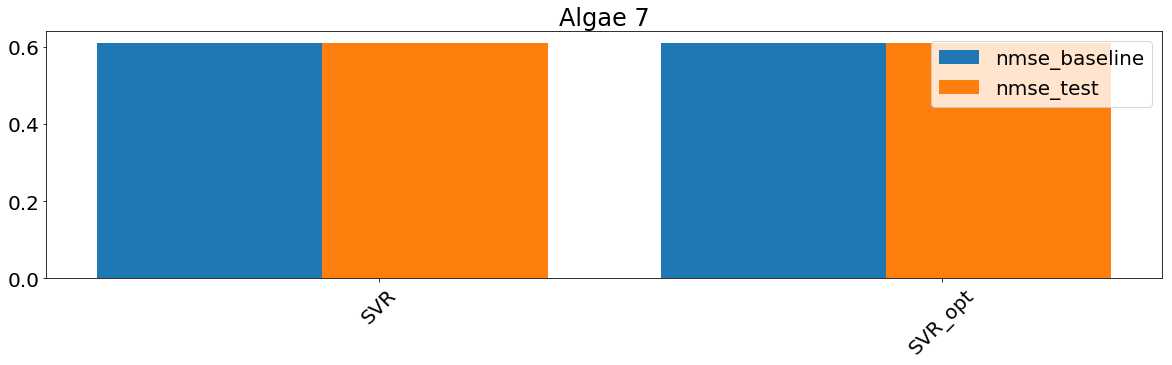

SVR_mae_train_1	 13.310857955174981
SVR_mae_test_1	 11.4750784640279
SVR_mae_baseline_1	 12.239130434782611
SVR_nmse_train_1	 0.18
SVR_nmse_test_1	 0.183
SVR_nmse_baseline_1	 0.183
SVR_opt_mae_train_1	 13.24442755152139
SVR_opt_mae_test_1	 11.42608307265896
SVR_opt_mae_baseline_1	 12.239130434782611
SVR_opt_nmse_train_1	 0.18
SVR_opt_nmse_test_1	 0.183
SVR_opt_nmse_baseline_1	 0.183
SVR_mae_train_2	 6.64640913728299
SVR_mae_test_2	 5.914330030298431
SVR_mae_baseline_2	 6.5547826086956515
SVR_nmse_train_2	 0.335
SVR_nmse_test_2	 0.304
SVR_nmse_baseline_2	 0.304
SVR_opt_mae_train_2	 6.636383854021997
SVR_opt_mae_test_2	 5.895837584018476
SVR_opt_mae_baseline_2	 6.5547826086956515
SVR_opt_nmse_train_2	 0.335
SVR_opt_nmse_test_2	 0.304
SVR_opt_nmse_baseline_2	 0.304
SVR_mae_train_3	 4.250001282745135
SVR_mae_test_3	 3.4822529156419137
SVR_mae_baseline_3	 3.6199999999999997
SVR_nmse_train_3	 0.317
SVR_nmse_test_3	 0.443
SVR_nmse_baseline_3	 0.443
SVR_opt_mae_train_3	 4.258576835700356
SVR_o

In [168]:
# The results dictionary is cleared and the scaled SVR models aare compared withour the linear regression model
results = {}

models = {
          'SVR' : 'SVR()',
          'SVR_opt' : 'SVR(kernel="rbf", C=500, gamma=.0001)',  
         }

test_models(True)
for k , v in results.items(): # iterating freqa dictionary
        print(k+"\t", v)

## ANN time series prediction

## Hyperparameter Tuning of SVR with Random Search and Cross Validation

The test_models functions is adapted to make a function for hyparameter tuning  --> hyperaram_tune




# Interpret the Model


In [ ]:
# Extract the feature importances into a dataframe
model = LinearRegression()
feature_results = pd.DataFrame({'feature': list(x_train_.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)


In [ ]:
#https://stackoverflow.com/questions/46575729/find-the-most-import-features-for-a-svm-classification



from sklearn.datasets import load_breast_cancer
print(type(load_breast_cancer().target))


In [ ]:
lin_clf = SVR(kernel='linear')
lin_clf.fit(x_train, y_train)
scores = np.dot(x_train, lin_clf.coef_.T)

In [ ]:
# b0 = y_train==0 # boolean or "mask" index arrays
# b1 = y_train==1
# malignant_scores = scores[b0]
# benign_scores = scores[b1]       

In [ ]:
# https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
    
def f_importances(coef, names):
    imp = coef
    imp, names = zip(*sorted(zip(imp,names)))
    y_pos = range(len(names))
    plt.bar(y_pos, imp, align='center', alpha=0.5)
    plt.xticks(y_pos, names, rotation=45)
    plt.tick_params(labelsize = 20)
    return imp, names


features_names = list(x_train_.columns.values)

svr = SVR(kernel='linear')
svr.fit(x_train, y_train)
imp_features, imp_names = f_importances(svr.coef_.tolist()[0], features_names)


## Use Feature Importances for Feature Selection

In [ ]:
# Extract the names of the most important features
most_important_features = imp_names[:3] + imp_names[-3:]

# Find the index that corresponds to each feature name
indices = [list(x_train_.columns).index(i) for i in most_important_features]

# Keep only the most important features
x_train_reduced = x_train[:, indices]
x_test_reduced = x_test[:, indices]

print('Most important training features shape: ', x_reduced.shape)
print('Most important testing  features shape: ', x_test_reduced.shape)

### Re-run the training and testing code from before, replacing x_train and x_test with x_train_reduced and x_test_reduced

Linear regression results significantly improve



In [ ]:

def fit_and_evaluate_v2(model, X_train, Y_train, X_test, Y_test):
    
    # Train the model
    model.fit(X_train, Y_train)
    
    # Make predictions and evalute
    # check the model correctly predicts the training data
    y_pred_train = model.predict(X_train)
    y_mae_train = np.round(mae(Y_train, y_pred_train), decimals=3)
    y_nmse_train = np.round(
        nmse(Y_train.reshape(-1, 1),
             y_pred_train.reshape(-1, 1)), 
        decimals=3) 


    # predict the real data
    y_pred_test = model.predict(X_test)   
    y_mae_test = np.round(mae(Y_test, y_pred_test), decimals=3)
    y_nmse_test = np.round(
        nmse(Y_test.reshape(-1, 1),
             y_pred_test.reshape(-1, 1)), 
        decimals=3) 
    print(r2_score(y_pred_test, Y_test))
    # PLOT refined MODEL PREDICTION  
    plt.figure()
    plt.subplot(2, 2, 2)
    plt.plot(y_pred_test,'b', label="predicted")
    plt.plot(Y_test,'r', label="real")
    plt.legend()

      
    # baseline performance
    baseline_guess = np.median(Y_train)
    y_mae_baseline = np.round(mae(Y_test, baseline_guess), decimals=3)
    y_nmse_baseline = np.round(
        nmse(Y_test.reshape(-1, 1),
             np.full_like(Y_test.reshape(-1, 1),baseline_guess)),
        decimals=3) 
    

    # Return the performance metric
    return y_pred_train, y_mae_train, y_nmse_train, y_pred_test, y_mae_test, y_nmse_test, y_mae_baseline, y_nmse_baseline


# Defining the columns in a list in order to use it in the for loop
algae_type=['Algae 1','Algae 2','Algae 3','Algae 4','Algae 5','Algae 6','Algae 7'] 

# this counter is used to call each algae type (for the plots and other printing porpuses)
counter=0; 
plt.rcParams['figure.figsize'] = [20, 10]

# y is the algae concentration
# x is the features 
from sklearn.preprocessing import normalize

# this for loop will run for each algae type once 
for A in algae_type: 
    counter=counter+1
    
#     # reading the training dataset (we generated this before) 
#     x_train_ = pd.read_csv('data/polished_train_data.csv').drop(columns=algae_type, axis=1) 
#     y_train_ = pd.read_csv('data/polished_train_data.csv', usecols=[A])
#     # dataframe --> array
#     x_train = x_train_.values
#     y_train = y_train_.values.ravel() # Convert y to one-dimensional array (vector)
#     # y_train = np.array(y_train_).reshape((-1, ))
    
#     #reading the test data set (we generated this before)
#     x_test_ = pd.read_csv('data/polished_test_data.csv').drop(columns=algae_type, axis=1) 
#     y_test_ = pd.read_csv('data/polished_test_data.csv', usecols=[A])
#     # dataframe --> array
#     x_test = x_test_.values
#     y_test = y_test_.values.ravel() # Convert y to one-dimensional array (vector)
    # y_test = np.array(y_test_).reshape((-1, ))
    
    
    # Scale values
    # Create the scaler object with a range of 0-1
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Fit on the training data
    scaler.fit(x_train)
    # Transform both the training and testing data
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)    
    
#     print(x_train.shape)
#     print(x_test.shape)
#     print(y_train.shape)
#     print(y_test.shape)
#     print()
    print(f"{A}") 
    
    # LinearRegression
    mod = 'Linear Regression'
    pred_train, mae_train, nmse_train, pred_test, mae_test, nmse_test, mae_baseline, nmse_baseline = fit_and_evaluate_v2(LinearRegression(), x_train_reduced, y_train, x_test_reduced, y_test)
    print(f"{ mod } Performance : \n" +
          f"train set : MAE = {mae_train}, NMSE = {nmse_train} \n" +
          f"test set : MAE = { mae_test},  NMSE = {nmse_test} \n" +
          f"baseline : MAE = { mae_baseline}, NMSE = { nmse_baseline}")
    print()
    
    # SVR
    mod = 'SVR'
    pred_train, mae_train, nmse_train, pred_test, mae_test, nmse_test, mae_baseline, nmse_baseline = fit_and_evaluate_v2(SVR(), x_train_reduced, y_train, x_test_reduced, y_test)
    print(f"{ mod } Performance : \n" +
          f"train set : MAE = {mae_train}, NMSE = {nmse_train} \n" +
          f"test set : MAE = { mae_test},  NMSE = {nmse_test} \n" +
          f"baseline : MAE = { mae_baseline}, NMSE = { nmse_baseline}")
    print()
    
    # SVR, optimised
    mod = 'SVR, optimised'
    pred_train, mae_train, nmse_train, pred_test, mae_test, nmse_test, mae_baseline, nmse_baseline = fit_and_evaluate_v2(SVR(kernel='rbf', C=500, gamma=.0001), x_train_reduced, y_train, x_test_reduced, y_test )
    print(f"{ mod } Performance : \n" +
          f"train set : MAE = {mae_train}, NMSE = {nmse_train} \n" +
          f"test set : MAE = { mae_test},  NMSE = {nmse_test} \n" +
          f"baseline : MAE = { mae_baseline}, NMSE = { nmse_baseline}")
    print()
    
    
    print()
    
    